In [2]:
import numpy as np
from scipy.stats import norm
import copy
import matplotlib.pyplot as plt
from __future__ import division

In [ ]:
class agent_based_model:
    
    """set the model as object"""
    
    # constructor
    def __init__(self, v=1 , N_regions=42, dt=0.01, sconn_len=None, sconn_den=None, snca=None, gba=None, roi_size=None, fconn=None, fcscale=None):
        
        # number of regions
        self.N_regions = N_regions
        
        # store number of normal and misfolded proteins in regions
        self.nor = np.zeros((N_regions,), dtype = np.int)
        self.nor_history = np.empty((0, N_regions), dtype = np.int)
        self.mis = np.zeros((N_regions,), dtype = np.int)
        self.mis_history = np.empty((0, N_regions), dtype = np.int)
        
        
        # store number of normal and misfolded proteins in paths
        self.sconn_len = np.int_(np.round(sconn_len / v))
        (self.idx_x, self.idx_y) = np.nonzero(self.sconn_len)
        self.non_zero_lengths = self.sconn_len[self.idx_x, self.idx_y]  # int64
        self.path_nor, self.path_mis = [ [ [[] for y in range(N_regions)] for x in range(N_regions)] ] * 2
        
        #### is there more efficient way to do this?  --- to be updated.......
        for x, y, v in zip(self.idx_x, self.idx_y, self.non_zero_lengths):
            self.path_nor[x][y], self.path_mis[x][y] = [ [0 for k in range(v)] ] * 2
            
        # record the trajectory
        self.path_nor_history = []
        self.path_mis_history = []
        
        # continuous path and path history
        self.path_nor_cont, self.path_mis_cont = [np.zeros((N_regions, N_regions), dtype = np.int)] * 2
        self.path_nor_cont_history, self.path_mis_cont_history = [np.empty((0, self.N_regions, self.N_regions))] * 2
        
        # time step
        self.dt = dt
        
        # synthesis rate and clearance rate
        self.synthesis_rate = norm.cdf(snca) * self.dt
        self.clearance_rate = norm.cdf(gba) * self.dt       
        
        # probability of exit a path is set to v/sconn_len
        sconn_len[sconn_len ==0] = np.inf
        self.prob_exit = self.dt * v / sconn_len
        self.prob_exit[sconn_len==0] = 0 # remove NaNs....
        
        # travel weights
        self.weights = np.exp(fcscale * fconn) * sconn_den
        
        self.weights = np.sum(self.weights, axis = 1) * np.eye(self.N_regions) + self.weights
        
        # scale 
        self.weights = self.weights / np.sum(self.weights, axis = 1).reshape(self.N_regions, 1)
        
        # region size
        self.roi_size = roi_size.flatten()
        
        self.synthesis_control = np.int_(roi_size.flatten())
        
                
    def normal_alpha_syn_growth_region(self):
        """step: normal alpha-syn synthesized and cleared in regions"""

        self.nor -= np.array([np.sum(np.random.uniform(0, 1, (v, )) < k) 
                             for k, v in zip(self.clearance_rate, self.nor)])
        
        
        ## synthesis
        self.nor += np.array([np.sum(np.random.uniform(0, 1, (v, )) < k) 
                              for k, v in zip(self.synthesis_rate, self.synthesis_control) ])
                              # or self.roi_size)])
    
    def normal_alpha_syn_growth_edge_discrete(self):
        """proteins are moving discretely in edges"""
        # alpha syn  -- from region to path
        # exit region
        exit_process = np.array([ np.random.multinomial(self.nor[k], self.weights[k]) 
                                 for k in range(self.N_regions)], dtype = np.int)
        
        # alpha syn -- from path to region
        # enter region
        enter_process = np.zeros((self.N_regions, self.N_regions), dtype=np.int)
        
        for x, y in zip(self.idx_x, self.idx_y):
            # fetch then remove the last element
            enter_process[x, y] = self.path_nor[x][y].pop()
            # update paths
            self.path_nor[x][y].insert(0, exit_process[x, y])

        # update regions 
        self.nor = exit_process[np.nonzero(np.eye(self.N_regions))] + np.sum(enter_process, axis = 0)
        
    def normal_alpha_syn_growth_edge_continuous(self):
        """proteins are moving contiously in edges"""
        
        # exit regions:
        exit_process = np.array([ np.random.multinomial(self.nor[k], self.weights[k]) 
                                 for k in range(self.N_regions)], dtype = np.int)
        
        # enter regions:
        enter_process = np.zeros((self.N_regions, self.N_regions), dtype = np.int)
        
        for x, y in zip(self.idx_x, self.idx_y):
            enter_process[x, y] = np.sum(np.random.uniform(0, 1, (self.path_nor_cont[x, y], )) < self.prob_exit[x, y])
        
        # update:
        self.path_nor_cont += (exit_process - enter_process)
        self.path_nor_cont[np.eye(self.N_regions)==1] == 0
        self.path_nor = exit_process[np.nonzero(np.eye(self.N_regions))] + np.sum(enter_process, axis = 0)
        
        
    def inject_mis(self, seed=42, initial_number=1):
        
        """inject initual_number misfolded protein into seed region"""
        # initial_number must be an interger
        self.mis[seed] = initial_number
        #print('inject %d misfolded alpha-syn into region %d' % (initial_number, seed))
        
    
    def misfolded_alpha_syn_spread_edge_discrete(self):
        """ step in paths for normal and misfolded alpha syn"""
        
        ############## misfolded alpha synuclein ###########
        # exit regions
        exit_process = np.array([ np.random.multinomial(v, self.weights[k]) 
                                 for k, v in enumerate(self.mis)], dtype = np.int)
        # alpha syn -- from path to region
        # enter region
        enter_process = np.zeros((self.N_regions, self.N_regions), dtype = np.int)
        for x, y in zip(self.idx_x, self.idx_y):
            # fetch then remove the last element
            enter_process[x, y] = self.path_mis[x][y].pop()
            # update paths
            self.path_mis[x][y].insert(0, exit_process[x, y])

        # update regions 
        self.mis = exit_process[np.nonzero(np.eye(self.N_regions))] + np.sum(enter_process, axis = 0)
        
        ########### for the normal alpha syuclein ###########
        exit_process = np.array([ np.random.multinomial(self.nor[k], self.weights[k]) 
                                 for k in range(self.N_regions)], dtype = np.int)
        
        # alpha syn -- from path to region
        # enter region
        enter_process = np.zeros((self.N_regions, self.N_regions), dtype=np.int)
        
        for x, y in zip(self.idx_x, self.idx_y):
            # fetch then remove the last element
            enter_process[x, y] = self.path_nor[x][y].pop()
            # update paths
            self.path_nor[x][y].insert(0, exit_process[x, y])

        # update regions 
        self.nor = exit_process[np.nonzero(np.eye(self.N_regions))] + np.sum(enter_process, axis = 0)
        
    def misfolded_alpha_syn_spread_edge_continous(self):
        """proteins are moving continously"""
        ##### misfolded alpha synuclein #####
        exit_process = np.array([ np.random.multinomial(v, self.weights[k]) 
                                 for k, v in enumerate(self.mis)], dtype = np.int)
        
        enter_process = np.zeros((self.N_regions, self.N_regions), dtype = np.int)
        
        # enter regions:
        for x, y in zip(self.idx_x, self.idx_y):
            enter_process[x, y] = np.sum(np.random.uniform(0, 1, (self.path_mis_cont[x, y], )
                                                          ))< self.prob_exit[x, y]
        
        # update
        self.path_mis_cont += (exit_process - enter_process)
        self.path_mis_cont[np.eye(self.N_regions)==1] == 0
        self.mis = np.sum(enter_process, axis = 0) + exit_process[np.nonzero(np.eye(self.N_regions))]
        
        ####### normal alpha synuclein #######
        # exit regions:
        exit_process = np.array([ np.random.multinomial(self.nor[k], self.weights[k]) 
                                 for k in range(self.N_regions)], dtype = np.int)
        
        # enter regions:

        enter_process = np.zeros((self.N_regions, self.N_regions), dtype = np.int)
        
        for x, y in zip(self.idx_x, self.idx_y):
            enter_process[x, y] = np.sum(np.random.uniform(0, 1, (self.path_nor_cont[x, y], ) 
                                                          ) )< self.prob_exit[x, y]
        
        # update:
        self.path_nor_cont += (exit_process - enter_process)
        self.path_nor_cont[np.eye(self.N_regions)==1] == 0
        self.path_nor = exit_process[np.nonzero(np.eye(self.N_regions))] + np.sum(enter_process, axis = 0)
        
    def misfolded_alpha_syn_spread_region(self, trans_rate=1):
        """clearance and synthesis of normal/misfolded alpha-syn/ transsmssion process in regions"""
        ## clearance
        cleared_nor = np.array([np.sum(np.random.uniform(0, 1, (v, )) < k) 
                             for k, v in zip(self.clearance_rate, self.nor)])
        
        cleared_mis = np.array([np.sum(np.random.uniform(0, 1, (v, )) < k) 
                             for k, v in zip(self.clearance_rate, self.mis)])
        
        self.prob_infected = 1 - np.exp(- (self.dt * self.mis * trans_rate / (self.roi_size)) )
        # the remaining after clearance
        self.nor -= cleared_nor
        self.mis -= cleared_mis
        #self.prob_infected = 1 - np.exp(- (self.mis / self.roi_size) )
        infected_nor = np.array([np.sum(np.random.uniform(0, 1, (v, )) < k) 
                             for k, v in zip(self.prob_infected, self.nor)])
        # update self.nor and self.mis
        self.nor += (np.array([np.sum(np.random.uniform(0, 1, (v, )) < k) 
                              for k, v in zip(self.synthesis_rate, self.roi_size)]) - infected_nor)
        self.mis += infected_nor 
        
        #print(self.mis)
        
    def transmission_path(self, trans_rate_path):
        
        """transmission process in path (default shut down)"""
        for x, y, v in zip(self.idx_x, self.idx_y, self.non_zero_lengths):
            ### perhaps trans_rate_path should be set to 1/v ?
            # transmission rate is scaled by exp(distance) in voxel space
            path_nor_temp = np.array(self.path_nor[x][y])
            path_mis_temp = np.array(self.path_mis[x][y])
            rate_get_infected = (path_mis_temp * trans_rate_path) / np.exp(np.absolute(np.arange(v) - np.arange(v)[np.newaxis].T) )
            prob_get_infected = 1 - np.exp(np.sum(-rate_get_infected, axis = 1))
            infected_path = np.array([np.sum(np.random.uniform(0, 1, (k, ))<v) for 
                                      k, v in zip(self.path_nor[x][y], prob_get_infected)])
            
            # update self.path_nor and self.path_mis
            path_nor_temp -= infected_path
            path_mis_temp += infected_path
            
            self.path_nor[x][y] = path_nor_temp.tolist()
            self.path_mis[x][y] = path_mis_temp.tolist()
            
        
    def record_to_history_discrete(self):
        """record the results of each step into the recorder"""
        self.nor_history = np.append(self.nor_history, self.nor[np.newaxis], axis = 0)
        self.mis_history = np.append(self.mis_history, self.mis[np.newaxis], axis = 0)
        
        # record the mobility patterns in edges
        #self.path_nor_history.append(self.path_nor)
        #self.path_mis_history.append(self.path_mis)
        
    def record_to_history_continous(self):
        """record the results of each step"""
        self.nor_history = np.append(self.nor_history, self.nor[np.newaxis], axis = 0)
        self.mis_history = np.append(self.mis_history, self.mis[np.newaxis], axis = 0)
        
        # record the mobility patterns in edges
        #self.path_nor_cont_history = np.append(self.path_nor_cont_history, self.path_nor_cont.reshape(1, 42, 42), axis = 0)
        #self.path_mis_cont_history = np.append(self.path_mis_cont_history, self.path_mis_cont.reshape(1, 42, 42), axis = 0)
        

In [23]:
class SIR_model:
    """An SIR model to simulate the spread of alpha-syn"""
    
    # constructor
    def __init__(self, v , N_regions, sconn_len, sconn_den, snca, gba, dat, roi_size):
        
        # number of regions
        self.N_regions = N_regions
        
        # store number of normal and misfolded proteins in regions
        self.nor = np.zeros((N_regions, ))
        self.mis = np.zeros((N_regions, ))
        self.nor_history = np.empty((0, N_regions))
        self.mis_history = np.empty((0, N_regions))
        
        # store number of normal and misfoded proteins in paths
        self.path_nor = np.zeros((N_regions, N_regions))
        self.path_mis = np.zeros((N_regions, N_regions))
        self.path_nor_history = np.empty((0, N_regions, N_regions))
        self.path_mis_history = np.empty((0, N_regions, N_regions))
        
        # index of connected components
        (self.idx_x, self.idx_y) = np.nonzero(sconn_len)
        self.non_zero_lengths = sconn_len[np.nonzero(sconn_len)]
        
        # probability of exit a path is set to v/sconn_len
        sconn_len2 = sconn_len.copy()
        sconn_len2[sconn_len2 == 0] = np.inf
        self.prob_exit = v / sconn_len2
        self.prob_exit[sconn_len2==0] = 0
        
        # synthesis rate and  clearance rate
        self.synthesis_rate = norm.cdf(snca) * 0.2
        self.clearance_rate = 1 - np.exp( -norm.cdf(gba))
        #self.stay_rate = norm.cdf(dat)  # yet to be modified .. what the hell is it?!
        
        # get travel weights  --- to be modified 
        self.weights = np.diag(np.sum(sconn_den, axis = 1)) + sconn_den
        self.weights = self.weights / np.sum(self.weights, axis = 1)[np.newaxis].T
        
        # region size
        self.roi_size = roi_size.flatten() / 8
        
        
    def nor_step_region(self):
        """normal alpha-syn growing"""
        self.nor += (self.roi_size * self.synthesis_rate - self.nor * self.clearance_rate)
        
    def nor_travel(self):
        
        # enter paths
        enter_process = self.nor[np.newaxis].T * self.weights
        
        # exit paths
        exit_process = self.path_nor * self.prob_exit
        
        # update paths and regions  ------- feels a bit weird.... to be updated
        self.nor = enter_process[np.nonzero(np.eye(self.N_regions))] + np.sum(exit_process, axis = 0)
        self.path_nor += (enter_process - exit_process)
        self.path_nor[np.eye(self.N_regions)==1] = 0
        
        
    def inject_mis(self, seed, initial_number):
        """inject misfolded alpha-syn in seed region"""
        
        self.mis[seed] = initial_number
        print('now we inject %d misfolded alpha-syn into region %d' % (initial_number, seed))
        
    def mis_travel(self):
        
        # enter paths
        enter_process = self.mis[np.newaxis].T * self.weights
        
        # exit paths
        exit_process = self.path_mis * self.prob_exit
        
        # update paths and regions  ------- feels a bit strange.... to be updated
        self.mis = enter_process[np.nonzero(np.eye(self.N_regions))] + np.sum(exit_process, axis = 0)
        self.path_mis += (enter_process - exit_process)
        self.path_mis[np.eye(self.N_regions)==1] = 0
        
        
    def transmission_region(self, trans_rate):
        
        '"""the transmission process inside regions"""'
        prob_get_infected = 1 - np.exp(-self.mis * trans_rate / self.roi_size)
        # clear process
        self.nor -= self.nor * self.clearance_rate
        self.mis -= self.mis * self.clearance_rate
        
        infected = self.nor * prob_get_infected
        self.nor += (self.roi_size * self.synthesis_rate - infected)
        self.mis += (infected)
        print(self.mis)
        
    def transmission_path(self):
        
        """the transmission process in paths"""
        ### what's the rule of transmission? 
        pass
    
    def record_to_history(self):
        """record the results"""
        self.nor_history = np.append(self.nor_history, self.nor[np.newaxis], axis = 0)
        self.mis_history = np.append(self.mis_history, self.mis[np.newaxis], axis = 0)
        
        self.path_nor_history = np.append(self.path_nor_history, 
                                          self.path_nor.reshape(1, self.N_regions, self.N_regions), axis = 0)
        self.path_mis_history = np.append(self.path_mis_history, 
                                          self.path_mis.reshape(1, self.N_regions, self.N_regions), axis = 0)
        
        

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.stats.stats import zscore,pearsonr

In [39]:
para = loadmat('/Users/yingqiuzheng/Desktop/Research/PD/Lh/DTIseeds/Resol1/parameters_final_normalized.mat')

In [40]:
sconn_len = np.array(para['sc_len_total'])
sconn_den = np.array(para['sc_ncount_n_total'])
roi_size = np.array(para['ROIsize'])
gba = para['GBA']
snca = para['SNCA']
real_atrophy = para['real_atrophy']

In [24]:
ref_model = agent_based_model(v=1 , N_regions=42, dt=0.01, sconn_len=sconn_len, sconn_den=sconn_den, snca=snca.flatten(), gba=gba.flatten(), roi_size=roi_size.flatten(), fconn=np.zeros((42, 42)), fcscale=0)

In [25]:
for t in range(10000):
    ref_model.record_to_history_continous()
    ref_model.normal_alpha_syn_growth_edge_continuous()
    ref_model.normal_alpha_syn_growth_region()
    print(ref_model.nor)    

[ 64  25   7  48  48  65 163 275  72 123  43  42  15  46  28  77 101  99
 123  72  19   2  67  43 111  17   7  26 135 144  22 148  15  70   0   2
   4   0   0  25   6   0]
[146  44  10  88  96 117 320 526 121 230  66  73  38  76  51 179 212 209
 221 160  24   5 142  75 210  39  21  50 238 284  53 273  28 155   0   4
   5   0   1  55  12   1]
[222  66  16 130 133 179 468 783 188 334 102 115  64 114  71 253 334 303
 334 230  46  10 192 114 309  55  38  73 375 429  83 418  30 238   0   4
   7   0   1  75  17   2]
[ 292   91   20  172  159  229  625 1017  255  450  120  149   75  156   91
  320  455  397  443  319   55   14  248  131  418   65   52   97  506  551
  117  558   40  316    0    6   10    0    1   95   19    2]
[ 369  111   28  206  200  277  816 1268  309  549  143  177   87  196  112
  403  572  513  546  396   66   19  315  169  512   81   63  111  617  686
  134  691   47  415    0    7   14    0    2  116   25    3]
[ 452  136   34  253  244  342  982 1503  372  645  173 

[2786  782  227 1595 1479 1796 5839 8939 2257 3771 1068 1140  625 1262  827
 2968 4129 3936 4243 2929  612  218 2394 1416 3690  571  447  783 4130 4804
  948 5128  425 2640    0   48   90    2   32  762  237   44]
[2842  791  231 1620 1510 1814 5986 9119 2312 3868 1090 1165  643 1284  838
 3040 4228 4029 4337 2986  634  223 2456 1448 3783  587  460  796 4236 4909
  968 5262  437 2706    0   49   90    2   33  777  249   47]
[2903  811  236 1658 1544 1848 6138 9319 2357 3950 1121 1189  650 1301  861
 3078 4331 4137 4463 3054  644  226 2501 1476 3877  608  467  812 4326 5005
  991 5373  443 2779    0   51   91    2   34  790  255   46]
[2973  821  239 1696 1572 1871 6247 9568 2412 4041 1146 1214  658 1321  876
 3142 4422 4226 4545 3115  662  231 2534 1503 3980  610  475  823 4413 5109
 1012 5502  448 2828    0   51   92    1   37  796  260   46]
[3027  839  250 1738 1615 1903 6372 9733 2460 4124 1175 1234  669 1358  888
 3218 4527 4315 4627 3187  679  240 2600 1542 4044  624  485  851 45

[ 4630  1354   412  2595  2443  2955  9787 14630  3900  6439  1937  1860
  1085  2167  1393  5110  6960  6974  7346  5079  1074   395  4344  2577
  6234   966   754  1266  6962  7997  1676  8565   738  4490     0    89
   139     5    71  1343   460    70]
[ 4671  1373   417  2621  2479  2997  9881 14787  3941  6545  1953  1869
  1093  2188  1407  5168  7044  7028  7414  5153  1089   402  4409  2609
  6300   969   760  1268  7055  8092  1702  8652   757  4549     0    93
   140     5    72  1355   466    71]
[ 4700  1397   424  2639  2516  3030 10025 14914  3982  6632  1972  1876
  1095  2212  1419  5229  7139  7099  7495  5219  1105   403  4443  2652
  6380   981   760  1276  7128  8185  1712  8764   759  4605     0    95
   141     5    73  1373   475    73]
[ 4751  1411   431  2669  2535  3052 10129 15072  4021  6688  1995  1903
  1108  2237  1442  5294  7203  7198  7569  5271  1119   407  4486  2686
  6458   999   763  1284  7219  8237  1737  8884   773  4648     0    95
   144    

[ 6001  1868   573  3313  3114  3757 12801 18670  5126  8525  2658  2265
  1405  2819  1887  6762  9118  9383  9965  6962  1515   551  5959  3683
  8138  1257   979  1602  9047 10383  2313 11456  1038  5811     1   134
   199     8    94  1832   648    81]
[ 6038  1880   578  3333  3150  3784 12881 18775  5170  8583  2681  2278
  1413  2838  1899  6819  9185  9454 10025  7045  1523   554  6017  3709
  8184  1259   991  1613  9128 10439  2325 11548  1054  5844     1   136
   198     8    95  1846   655    81]
[ 6079  1889   583  3347  3170  3799 12945 18890  5194  8638  2702  2282
  1423  2843  1913  6863  9220  9516 10096  7099  1541   557  6057  3756
  8263  1268  1001  1630  9182 10494  2352 11620  1055  5863     1   138
   199     8    95  1859   658    82]
[ 6132  1899   586  3371  3180  3817 13034 19002  5208  8716  2739  2283
  1425  2864  1933  6913  9280  9598 10153  7135  1559   563  6097  3792
  8305  1278  1008  1635  9233 10560  2371 11686  1062  5894     1   138
   203    

[ 7094  2281   696  3968  3667  4388 15157 21884  6037 10421  3231  2633
  1669  3368  2190  8249 10849 11574 12211  8426  1920   687  7329  4795
  9571  1484  1185  1905 10887 12352  2882 13865  1290  6887     2   173
   257    11   129  2278   833    93]
[ 7128  2296   698  3971  3681  4420 15244 21943  6055 10468  3247  2638
  1680  3387  2201  8297 10916 11636 12262  8478  1925   692  7367  4834
  9628  1493  1191  1911 10939 12415  2903 13960  1301  6930     3   173
   259    10   130  2287   836    93]
[ 7162  2302   705  3992  3695  4450 15320 22081  6068 10513  3260  2631
  1697  3397  2202  8351 10944 11682 12325  8528  1939   698  7401  4847
  9670  1505  1189  1908 10970 12465  2917 14019  1310  6974     3   175
   261    10   132  2293   843    95]
[ 7182  2319   705  4008  3702  4471 15398 22137  6102 10542  3278  2647
  1712  3409  2213  8387 11012 11758 12375  8568  1951   703  7442  4882
  9706  1516  1194  1909 11015 12523  2929 14091  1317  7008     3   175
   262    

[ 7968  2703   810  4378  4103  4924 17447 24166  6785 11956  3663  2901
  1889  3868  2507  9543 12352 13425 14061  9760  2302   852  8597  5716
 10630  1715  1337  2017 12271 13880  3393 16106  1496  7820     3   203
   313     7   157  2616  1023   103]
[ 7993  2718   814  4402  4114  4929 17490 24270  6815 11989  3681  2917
  1891  3889  2520  9573 12399 13486 14131  9812  2306   860  8643  5739
 10683  1721  1334  2023 12326 13925  3411 16210  1503  7838     3   203
   314     7   160  2634  1031   103]
[ 8027  2740   810  4426  4131  4945 17592 24354  6817 12039  3703  2926
  1887  3902  2532  9621 12423 13536 14165  9844  2316   858  8685  5770
 10712  1722  1335  2027 12373 13976  3415 16250  1514  7871     3   206
   316     7   160  2641  1036   103]
[ 8046  2752   808  4429  4144  4955 17675 24404  6821 12063  3729  2944
  1902  3922  2531  9659 12457 13598 14233  9881  2332   864  8720  5788
 10766  1727  1335  2035 12410 14021  3448 16326  1521  7887     3   209
   317    

[ 8532  3075   878  4805  4392  5265 19231 26073  7367 13266  4053  3103
  2092  4156  2784 10622 13502 15243 15801 10912  2618  1009  9839  6639
 11633  1888  1445  2197 13460 14947  3934 17957  1729  8638     4   238
   379     9   179  2896  1185   118]
[ 8545  3082   882  4819  4380  5277 19282 26121  7380 13295  4072  3088
  2101  4161  2789 10667 13539 15279 15884 10957  2627  1012  9879  6681
 11677  1897  1443  2201 13481 14968  3943 18006  1739  8654     4   239
   382     9   179  2906  1190   118]
[ 8587  3092   882  4813  4380  5287 19321 26218  7413 13345  4104  3088
  2102  4188  2792 10684 13573 15315 15935 10994  2638  1018  9929  6714
 11702  1901  1439  2206 13529 14979  3967 18056  1746  8687     4   240
   385     9   180  2919  1194   119]
[ 8627  3109   884  4815  4385  5289 19382 26247  7414 13356  4131  3101
  2111  4198  2788 10698 13596 15364 15996 11018  2644  1019  9954  6743
 11715  1899  1441  2207 13549 15025  3985 18110  1752  8727     4   241
   386    

[ 9065  3405   988  5045  4602  5517 20658 27430  7880 14197  4448  3248
  2190  4521  2963 11591 14492 16790 17281 11902  2937  1149 10962  7524
 12335  2105  1520  2328 14346 15900  4397 19549  1906  9299     4   276
   434    12   203  3194  1355   106]
[ 9089  3416   991  5049  4607  5526 20726 27460  7901 14230  4446  3251
  2191  4534  2974 11618 14505 16841 17347 11919  2956  1156 10995  7549
 12375  2105  1522  2336 14399 15922  4421 19603  1915  9306     4   278
   439    12   203  3195  1363   105]
[ 9108  3426   999  5062  4602  5531 20770 27500  7899 14263  4472  3248
  2190  4530  2973 11641 14538 16883 17382 11984  2972  1157 11019  7579
 12394  2101  1523  2344 14438 15942  4435 19650  1922  9348     4   278
   439    12   203  3199  1372   104]
[ 9110  3442  1000  5048  4601  5540 20817 27538  7911 14285  4468  3259
  2185  4529  2975 11668 14552 16902 17443 12021  2987  1162 11053  7596
 12416  2105  1530  2336 14461 15980  4450 19701  1925  9354     4   278
   438    

[ 9556  3694  1051  5291  4830  5691 21810 28599  8339 15149  4682  3346
  2223  4786  3092 12413 15283 18133 18652 12814  3261  1316 11960  8359
 12896  2256  1605  2417 15187 16754  4818 20948  2099  9697     5   319
   497    11   224  3447  1535   107]
[ 9553  3705  1055  5286  4850  5694 21862 28662  8348 15164  4702  3336
  2223  4798  3099 12451 15312 18150 18677 12831  3274  1321 11994  8384
 12903  2252  1605  2423 15224 16767  4823 20982  2101  9728     5   322
   498    11   226  3455  1536   109]
[ 9567  3714  1060  5296  4835  5706 21893 28712  8356 15198  4699  3346
  2229  4798  3101 12480 15352 18211 18718 12863  3284  1326 12016  8416
 12900  2251  1595  2420 15230 16818  4839 20995  2110  9757     5   323
   499    11   227  3466  1541   111]
[ 9575  3720  1063  5320  4848  5715 21921 28754  8389 15235  4717  3358
  2231  4808  3114 12500 15379 18258 18774 12896  3290  1327 12050  8443
 12927  2244  1590  2426 15255 16824  4853 21026  2113  9770     5   325
   499    

[ 9876  3994  1117  5538  5044  5966 22880 29717  8776 15957  4910  3447
  2329  4929  3323 13075 15882 19285 19803 13638  3609  1475 12974  9235
 13293  2359  1639  2492 15773 17219  5197 21958  2227 10203     6   352
   553    11   249  3634  1724   116]
[ 9884  4006  1118  5551  5040  5962 22915 29738  8790 15974  4912  3449
  2328  4953  3337 13094 15894 19294 19828 13653  3613  1479 12996  9265
 13291  2364  1640  2493 15786 17243  5203 21989  2234 10213     6   352
   555    11   249  3650  1727   114]
[ 9893  4010  1122  5557  5034  5966 22932 29766  8803 15992  4921  3433
  2321  4951  3331 13132 15900 19323 19880 13695  3620  1484 13014  9290
 13313  2369  1635  2485 15801 17243  5211 22044  2230 10224     5   352
   557    11   249  3658  1735   115]
[ 9899  4019  1124  5554  5030  5962 22962 29812  8814 16005  4925  3440
  2326  4956  3328 13171 15941 19369 19911 13709  3631  1489 13042  9306
 13341  2380  1641  2490 15858 17267  5224 22067  2234 10245     5   353
   558    

[ 9991  4229  1182  5657  5193  6153 23707 30331  9010 16616  5086  3529
  2340  5111  3426 13777 16542 20251 20742 14369  3887  1655 13696 10026
 13697  2434  1723  2514 16288 17631  5486 22821  2384 10513     3   392
   600    11   269  3903  1872   125]
[10003  4232  1184  5671  5201  6159 23729 30376  9000 16634  5105  3516
  2341  5111  3433 13763 16554 20282 20771 14386  3900  1658 13726 10063
 13723  2443  1729  2516 16280 17652  5495 22878  2386 10530     3   394
   601    11   268  3910  1875   126]
[10017  4265  1183  5687  5205  6168 23753 30377  9016 16663  5116  3530
  2344  5111  3448 13778 16573 20324 20783 14378  3902  1661 13743 10084
 13723  2454  1716  2518 16272 17653  5514 22910  2390 10525     3   394
   603    11   268  3912  1881   126]
[10009  4271  1185  5708  5211  6155 23782 30403  9005 16698  5120  3539
  2353  5118  3440 13795 16608 20368 20818 14388  3917  1664 13756 10112
 13749  2450  1719  2527 16282 17637  5528 22944  2394 10543     3   396
   606    

[10133  4450  1282  5765  5333  6209 24384 30818  9173 17206  5321  3500
  2409  5192  3502 14311 17030 21258 21709 15021  4124  1815 14511 10835
 13968  2498  1740  2597 16644 18071  5769 23592  2530 10758     2   436
   643     7   285  4041  2053   124]
[10133  4449  1280  5772  5330  6215 24399 30844  9182 17211  5322  3499
  2412  5210  3514 14311 17027 21307 21744 15032  4134  1820 14530 10857
 13964  2503  1746  2602 16648 18077  5773 23604  2530 10748     2   438
   645     7   285  4043  2065   123]
[10137  4452  1283  5763  5337  6215 24413 30838  9175 17208  5320  3494
  2414  5213  3518 14306 17034 21353 21740 15061  4140  1824 14551 10886
 13960  2508  1753  2601 16654 18068  5794 23586  2533 10758     2   438
   647     7   285  4058  2074   121]
[10145  4445  1289  5767  5332  6220 24442 30878  9198 17232  5323  3488
  2405  5204  3528 14321 17027 21379 21769 15075  4155  1830 14568 10910
 13982  2500  1759  2596 16677 18067  5799 23642  2536 10782     2   438
   650    

[10329  4658  1331  5912  5393  6273 24862 31124  9341 17720  5524  3591
  2405  5307  3594 14620 17505 22097 22512 15509  4371  1982 15244 11580
 14146  2561  1765  2644 17072 18357  6086 24186  2688 10970     2   469
   697     8   298  4203  2236   123]
[10319  4666  1338  5908  5402  6281 24888 31119  9338 17721  5536  3604
  2422  5302  3603 14630 17507 22104 22525 15523  4384  1984 15277 11601
 14149  2556  1762  2647 17087 18350  6078 24231  2686 10980     2   469
   697     9   300  4207  2241   120]
[10324  4669  1347  5898  5393  6295 24881 31127  9342 17741  5539  3595
  2426  5299  3606 14634 17541 22117 22543 15535  4392  1992 15302 11620
 14161  2545  1760  2645 17115 18348  6088 24223  2695 10993     3   471
   700     9   301  4207  2245   120]
[10324  4678  1352  5915  5384  6291 24894 31096  9338 17764  5545  3593
  2425  5309  3608 14647 17568 22134 22560 15561  4403  1996 15345 11640
 14170  2545  1760  2648 17105 18350  6091 24208  2695 11007     3   471
   704    

[10646  4807  1338  5996  5443  6397 25095 31455  9506 18025  5752  3630
  2484  5399  3664 14970 17897 22642 23174 15863  4563  2128 15919 12322
 14342  2635  1795  2727 17531 18525  6295 24792  2787 11177     3   497
   771    10   321  4268  2387   115]
[10637  4818  1334  5996  5444  6376 25135 31444  9501 18044  5753  3637
  2471  5401  3673 14984 17917 22696 23216 15885  4570  2131 15920 12339
 14349  2642  1796  2731 17534 18550  6301 24799  2791 11159     3   499
   772    10   321  4271  2390   114]
[10627  4823  1339  6011  5447  6365 25149 31493  9503 18076  5755  3632
  2472  5383  3673 15010 17933 22742 23238 15895  4570  2136 15952 12364
 14346  2644  1800  2734 17516 18543  6303 24821  2790 11157     3   500
   771    10   320  4272  2393   115]
[10646  4822  1335  6024  5442  6358 25168 31506  9500 18103  5760  3636
  2479  5372  3676 15024 17951 22724 23255 15943  4577  2139 15969 12388
 14370  2646  1793  2737 17527 18551  6314 24814  2787 11171     3   502
   773    

[10879  4963  1356  6087  5384  6406 25616 31756  9588 18487  5864  3618
  2481  5368  3686 15213 18058 23182 23917 16341  4790  2272 16525 13026
 14436  2733  1747  2727 17871 18893  6515 25209  2880 11296     4   532
   815     9   345  4372  2546   107]
[10866  4961  1363  6090  5390  6407 25632 31758  9592 18481  5865  3622
  2488  5367  3694 15241 18050 23169 23921 16336  4798  2273 16548 13047
 14444  2739  1755  2732 17863 18893  6522 25217  2882 11320     4   533
   816     9   346  4377  2552   107]
[10856  4976  1362  6093  5399  6412 25622 31793  9585 18460  5876  3628
  2488  5367  3716 15253 18077 23188 23915 16347  4801  2276 16556 13066
 14452  2740  1758  2740 17883 18879  6534 25245  2884 11320     4   534
   818     9   346  4382  2555   104]
[10850  4980  1362  6102  5406  6413 25643 31816  9587 18451  5874  3637
  2488  5362  3715 15257 18088 23187 23936 16350  4815  2281 16566 13084
 14431  2738  1761  2734 17890 18876  6538 25255  2889 11322     4   535
   819    

[10925  5118  1375  6199  5371  6383 25798 32022  9606 18738  5944  3734
  2498  5427  3765 15462 18171 23739 24452 16625  4985  2414 17053 13681
 14546  2783  1780  2676 18042 19034  6672 25529  2965 11337     3   578
   861     8   363  4476  2713    97]
[10935  5128  1380  6198  5382  6372 25827 32052  9597 18739  5946  3738
  2509  5440  3766 15462 18182 23793 24488 16637  4997  2419 17061 13699
 14563  2786  1772  2680 18030 19019  6669 25542  2966 11354     3   578
   862     9   364  4478  2718    95]
[10951  5129  1379  6217  5393  6384 25815 31986  9605 18753  5941  3751
  2509  5466  3776 15469 18180 23804 24472 16640  5000  2424 17074 13716
 14562  2782  1774  2686 18051 19013  6675 25550  2969 11358     3   579
   862     9   364  4488  2720    96]
[10956  5127  1380  6230  5379  6397 25818 32008  9615 18734  5941  3758
  2504  5467  3780 15481 18225 23812 24487 16652  5012  2433 17084 13729
 14539  2784  1778  2685 18063 19002  6678 25552  2968 11378     3   579
   866    

[10883  5256  1415  6204  5479  6478 26050 32040  9637 18891  6035  3789
  2538  5527  3794 15730 18298 24345 24930 16889  5196  2570 17437 14293
 14620  2807  1817  2693 18005 19068  6825 25836  3035 11452     3   610
   914     9   377  4596  2876   101]
[10873  5262  1412  6193  5474  6479 26079 32028  9660 18893  6038  3786
  2546  5531  3777 15719 18298 24367 24919 16890  5198  2575 17435 14313
 14623  2806  1815  2690 18049 19084  6844 25854  3038 11455     3   610
   915     9   378  4605  2880   103]
[10874  5266  1421  6186  5497  6480 26111 32056  9639 18895  6033  3769
  2554  5515  3782 15725 18297 24381 24938 16916  5203  2579 17471 14334
 14613  2807  1815  2689 18036 19092  6847 25865  3038 11448     3   612
   915     9   380  4606  2885   105]
[10864  5277  1418  6188  5480  6482 26121 32041  9624 18906  6031  3770
  2545  5510  3783 15746 18295 24410 24962 16905  5224  2586 17485 14344
 14604  2812  1812  2679 18060 19104  6857 25891  3048 11436     3   612
   916    

[10978  5361  1433  6133  5512  6462 26401 32157  9626 19224  6195  3740
  2563  5571  3850 16019 18446 24890 25362 17218  5357  2729 17945 14941
 14565  2850  1842  2724 18300 19368  6975 26302  3139 11492     3   643
   955     8   404  4676  3029   110]
[10990  5370  1432  6125  5503  6478 26393 32127  9620 19226  6199  3751
  2562  5579  3849 16033 18455 24906 25382 17212  5356  2731 17955 14966
 14575  2847  1843  2736 18312 19359  6983 26294  3139 11488     3   643
   955     8   404  4676  3033   109]
[10985  5373  1429  6123  5512  6474 26432 32122  9623 19242  6199  3757
  2560  5583  3845 16041 18442 24922 25392 17215  5364  2737 17970 14979
 14572  2849  1833  2733 18293 19399  6981 26301  3143 11488     3   643
   956     8   404  4673  3036   109]
[10969  5375  1433  6118  5508  6479 26475 32119  9625 19231  6214  3749
  2566  5596  3852 16049 18451 24939 25411 17229  5376  2747 17980 14993
 14585  2852  1820  2726 18298 19436  6992 26319  3134 11485     3   643
   958    

[11035  5449  1453  6203  5485  6468 26572 32434  9695 19410  6306  3699
  2553  5609  3811 16222 18641 25207 25755 17425  5532  2865 18366 15547
 14634  2887  1791  2717 18370 19396  7171 26664  3230 11612     4   686
  1004     5   416  4761  3199   104]
[11026  5456  1453  6190  5488  6462 26545 32467  9697 19397  6292  3687
  2553  5601  3809 16238 18648 25227 25775 17448  5532  2868 18369 15558
 14616  2884  1789  2726 18379 19419  7175 26669  3230 11590     4   689
  1006     4   415  4769  3201   105]
[11015  5464  1448  6202  5473  6469 26515 32493  9711 19399  6302  3689
  2557  5610  3813 16239 18641 25215 25777 17460  5533  2871 18382 15573
 14639  2884  1786  2724 18386 19388  7181 26702  3228 11574     5   690
  1008     4   416  4759  3206   107]
[11011  5465  1449  6193  5478  6482 26525 32524  9684 19401  6292  3696
  2554  5634  3805 16241 18642 25230 25771 17477  5538  2878 18381 15585
 14612  2883  1781  2702 18398 19373  7180 26687  3234 11585     5   690
  1010    

[11109  5539  1457  6140  5552  6481 26706 32608  9707 19419  6364  3716
  2550  5618  3913 16354 18837 25517 26057 17713  5668  3005 18706 16128
 14606  2914  1820  2681 18416 19460  7330 26840  3307 11672     7   720
  1047     4   437  4827  3341   123]
[11113  5543  1460  6141  5536  6499 26711 32598  9696 19420  6361  3723
  2547  5611  3911 16352 18841 25529 26083 17727  5675  3009 18710 16151
 14622  2915  1824  2678 18420 19481  7346 26861  3309 11686     7   720
  1047     4   437  4829  3345   123]
[11101  5546  1457  6152  5527  6495 26725 32575  9696 19432  6369  3724
  2553  5634  3912 16350 18860 25567 26108 17753  5678  3014 18730 16169
 14636  2906  1831  2664 18454 19493  7341 26882  3312 11683     6   720
  1049     4   438  4834  3352   122]
[11102  5553  1460  6140  5512  6507 26709 32580  9690 19422  6362  3730
  2558  5625  3919 16372 18888 25573 26116 17770  5681  3020 18729 16187
 14631  2914  1825  2675 18477 19508  7341 26885  3316 11692     6   720
  1051    

[11136  5632  1463  6095  5581  6651 26882 32560  9714 19440  6411  3733
  2568  5636  3920 16562 19004 25735 26444 17941  5760  3156 19091 16653
 14634  2893  1840  2686 18570 19650  7490 27136  3334 11683     5   747
  1096     6   457  4904  3456   123]
[11108  5629  1461  6083  5590  6647 26886 32509  9721 19424  6413  3743
  2567  5644  3920 16573 19010 25722 26452 17951  5764  3164 19100 16665
 14658  2891  1846  2687 18602 19650  7493 27137  3327 11686     5   748
  1099     6   457  4902  3454   124]
[11111  5621  1464  6101  5590  6631 26886 32523  9702 19402  6395  3738
  2561  5646  3910 16588 19004 25703 26441 17969  5766  3172 19090 16671
 14651  2895  1843  2687 18617 19635  7497 27172  3333 11679     5   749
  1099     6   457  4903  3455   124]
[11099  5629  1465  6112  5604  6618 26903 32525  9711 19416  6392  3737
  2568  5636  3908 16594 18989 25699 26433 17960  5765  3174 19102 16683
 14642  2896  1848  2680 18620 19642  7493 27174  3337 11692     5   749
  1102    

[11049  5700  1428  6115  5585  6624 27067 32630  9765 19622  6408  3697
  2585  5639  3898 16748 19225 25958 26694 18180  5844  3306 19384 17238
 14845  2941  1870  2666 18500 19761  7592 27257  3409 11719     7   784
  1137     5   479  4940  3577   125]
[11040  5697  1436  6109  5582  6634 27108 32622  9779 19606  6414  3688
  2586  5649  3891 16745 19220 25968 26700 18196  5850  3314 19399 17260
 14855  2940  1868  2660 18513 19782  7595 27257  3407 11722     7   784
  1135     5   479  4935  3583   127]
[11060  5681  1439  6124  5570  6632 27097 32609  9775 19593  6433  3689
  2596  5636  3890 16742 19206 25971 26715 18189  5852  3317 19405 17275
 14841  2948  1864  2658 18521 19777  7602 27249  3402 11722     7   785
  1136     5   479  4929  3588   126]
[11056  5682  1436  6127  5571  6643 27081 32580  9775 19584  6431  3689
  2587  5645  3881 16745 19190 25985 26721 18192  5859  3322 19418 17292
 14848  2947  1863  2664 18508 19794  7629 27258  3392 11736     7   785
  1137    

[11034  5791  1441  6140  5586  6599 27210 32486  9817 19768  6438  3664
  2592  5646  3918 16832 19232 26186 26827 18319  5967  3448 19665 17655
 14883  2963  1873  2700 18640 19690  7700 27464  3440 11768     8   816
  1183     8   500  4975  3709   118]
[11048  5789  1437  6136  5575  6586 27213 32478  9820 19750  6449  3675
  2587  5659  3921 16843 19266 26196 26824 18344  5964  3452 19691 17658
 14835  2956  1871  2691 18660 19714  7702 27458  3448 11771     8   818
  1185     8   501  4987  3711   117]
[11053  5805  1436  6149  5570  6595 27202 32458  9825 19751  6447  3673
  2583  5664  3902 16842 19236 26190 26832 18353  5970  3454 19702 17657
 14818  2958  1869  2697 18690 19733  7711 27446  3459 11762     8   823
  1186     8   501  4987  3710   119]
[11070  5803  1435  6158  5569  6596 27178 32439  9826 19771  6449  3678
  2579  5673  3900 16839 19234 26184 26841 18339  5981  3457 19709 17673
 14832  2961  1871  2696 18683 19730  7720 27445  3457 11763     8   824
  1188    

[11121  5860  1422  6215  5530  6618 27319 32641  9803 20000  6462  3632
  2604  5679  3889 16914 19234 26450 27094 18421  6100  3582 20001 18136
 14892  2952  1894  2690 18810 19602  7795 27673  3536 11851     8   852
  1223     8   524  5065  3826   117]
[11128  5863  1426  6222  5554  6600 27310 32632  9804 19972  6462  3644
  2593  5680  3896 16927 19242 26442 27097 18425  6103  3586 20003 18154
 14914  2949  1903  2696 18788 19595  7798 27676  3532 11839     8   855
  1226     8   524  5056  3831   117]
[11118  5861  1429  6222  5546  6589 27318 32623  9802 19994  6472  3651
  2583  5680  3900 16937 19249 26447 27093 18406  6114  3590 20018 18186
 14897  2954  1908  2684 18780 19601  7808 27653  3541 11859     8   855
  1229     8   524  5053  3832   117]
[11124  5862  1426  6211  5548  6598 27317 32646  9817 19990  6468  3658
  2585  5689  3908 16942 19235 26454 27091 18397  6117  3593 20032 18208
 14890  2966  1904  2687 18765 19606  7817 27639  3533 11846     8   856
  1230    

[11211  5851  1440  6222  5531  6504 27328 32506  9865 20039  6486  3687
  2618  5673  3940 17076 19344 26612 27184 18559  6195  3729 20233 18607
 14883  2967  1895  2679 18752 19617  7887 27765  3533 11910     9   881
  1277     8   534  5002  3962   115]
[11213  5858  1447  6212  5529  6513 27303 32500  9852 20046  6483  3701
  2622  5671  3936 17070 19328 26638 27200 18542  6203  3733 20247 18613
 14872  2964  1894  2672 18738 19624  7887 27799  3531 11924     9   882
  1277     8   533  5001  3968   114]
[11204  5863  1446  6213  5529  6514 27322 32529  9832 20066  6507  3706
  2621  5671  3934 17069 19314 26681 27204 18520  6212  3736 20250 18636
 14867  2965  1894  2669 18741 19638  7874 27803  3535 11917     9   886
  1279     8   534  5011  3968   113]
[11214  5860  1441  6228  5524  6501 27322 32538  9820 20093  6502  3707
  2614  5668  3935 17076 19308 26688 27201 18529  6216  3737 20265 18653
 14877  2965  1889  2674 18725 19633  7876 27789  3542 11925     9   886
  1281    

[11084  5987  1434  6264  5541  6536 27431 32720  9842 20162  6548  3712
  2614  5712  3942 17171 19351 26655 27453 18536  6329  3854 20493 19050
 14871  2979  1908  2697 18605 19666  7895 28059  3539 11872     9   923
  1318     9   547  5034  4102   116]
[11092  5987  1438  6248  5541  6530 27414 32696  9848 20160  6550  3719
  2601  5709  3935 17176 19328 26672 27452 18513  6328  3859 20494 19070
 14871  2988  1905  2682 18628 19652  7896 28041  3536 11849     9   925
  1318     9   548  5027  4111   115]
[11089  5994  1437  6234  5533  6521 27414 32660  9842 20174  6557  3713
  2610  5703  3927 17177 19325 26669 27435 18526  6336  3863 20496 19090
 14875  2984  1903  2691 18642 19640  7913 28061  3534 11847     9   925
  1321     9   548  5021  4113   115]
[11091  5997  1437  6218  5533  6516 27424 32693  9840 20175  6561  3717
  2601  5697  3922 17177 19347 26692 27452 18524  6333  3868 20510 19101
 14879  2985  1909  2697 18651 19648  7917 28050  3543 11835    10   925
  1324    

[11108  5988  1428  6233  5506  6458 27247 32545  9854 20106  6515  3726
  2635  5691  3878 17156 19451 26803 27687 18561  6437  4007 20779 19432
 14835  3037  1929  2746 18709 19651  8038 28230  3563 11858     8   954
  1362    12   573  5059  4235   105]
[11090  5993  1432  6239  5506  6463 27234 32568  9869 20112  6503  3713
  2644  5703  3872 17147 19458 26818 27676 18560  6440  4017 20770 19440
 14858  3039  1929  2753 18711 19640  8036 28208  3570 11858     8   954
  1361    12   573  5047  4238   108]
[11094  5991  1434  6226  5511  6457 27224 32588  9860 20110  6526  3716
  2640  5709  3869 17153 19461 26829 27669 18576  6439  4020 20776 19451
 14858  3036  1934  2751 18713 19640  8032 28208  3574 11845     8   958
  1361    12   573  5037  4238   108]
[11077  5998  1437  6223  5509  6445 27226 32590  9840 20113  6523  3727
  2629  5710  3865 17162 19469 26837 27665 18588  6450  4021 20798 19465
 14872  3027  1927  2745 18715 19622  8041 28188  3579 11855     8   959
  1363    

[11126  6039  1444  6234  5471  6436 27366 32393  9841 20137  6554  3710
  2639  5646  3903 17087 19433 26902 27810 18690  6535  4158 20915 19778
 14878  3025  1920  2717 18816 19650  8128 28099  3627 11942     9   988
  1406    14   593  5059  4354   115]
[11120  6042  1446  6243  5485  6443 27360 32409  9834 20126  6565  3719
  2636  5641  3900 17081 19444 26911 27790 18703  6544  4164 20906 19784
 14850  3023  1922  2709 18811 19636  8135 28105  3626 11934     9   989
  1407    14   593  5056  4357   112]
[11111  6037  1442  6239  5485  6449 27347 32391  9848 20139  6574  3718
  2637  5653  3900 17106 19461 26926 27788 18724  6551  4167 20905 19809
 14834  3020  1918  2701 18810 19643  8147 28122  3627 11954     8   989
  1407    14   593  5044  4361   114]
[11115  6040  1446  6228  5469  6433 27344 32351  9842 20136  6568  3717
  2641  5664  3903 17120 19481 26943 27795 18742  6547  4170 20914 19828
 14842  3009  1920  2696 18823 19619  8158 28137  3623 11940     8   990
  1408    

[11103  6074  1448  6240  5394  6453 27269 32239  9860 20238  6575  3691
  2646  5685  3924 17110 19523 26999 27863 18754  6619  4318 21059 20226
 14818  3012  1924  2695 18952 19563  8147 28165  3631 12023     7  1019
  1461    12   608  5071  4464   111]
[11121  6077  1449  6237  5395  6467 27261 32229  9837 20223  6561  3689
  2639  5679  3923 17102 19540 26999 27882 18742  6619  4320 21056 20224
 14802  3009  1923  2693 18936 19546  8153 28163  3637 12024     7  1020
  1463    12   610  5063  4468   111]
[11119  6075  1448  6250  5399  6467 27265 32288  9843 20222  6555  3685
  2642  5678  3920 17104 19552 27006 27886 18760  6628  4319 21072 20239
 14781  3004  1923  2688 18976 19544  8162 28158  3643 12040     7  1020
  1462    12   612  5064  4475   110]
[11118  6071  1447  6226  5381  6477 27288 32265  9839 20218  6558  3685
  2641  5670  3917 17101 19567 27004 27887 18764  6625  4324 21077 20250
 14769  3005  1916  2693 18978 19568  8172 28167  3639 12027     7  1023
  1463    

[11165  6125  1479  6216  5391  6554 27335 32492  9753 20174  6551  3690
  2630  5700  3910 17267 19620 27032 28169 18786  6732  4446 21215 20590
 14827  3016  1928  2701 18907 19524  8285 28125  3639 12065     6  1047
  1512     9   633  5073  4588   127]
[11182  6113  1483  6213  5388  6558 27369 32477  9758 20166  6560  3688
  2635  5701  3918 17263 19624 27017 28167 18793  6726  4451 21217 20590
 14830  3015  1920  2688 18890 19501  8296 28156  3643 12062     6  1048
  1513     9   634  5069  4595   129]
[11174  6114  1486  6217  5386  6561 27385 32461  9748 20164  6563  3680
  2638  5685  3935 17263 19613 27045 28130 18824  6736  4458 21194 20598
 14818  3008  1915  2696 18880 19507  8295 28145  3636 12059     6  1048
  1511     9   633  5066  4596   129]
[11195  6110  1488  6230  5400  6549 27411 32458  9742 20163  6573  3671
  2642  5692  3935 17265 19615 27050 28116 18842  6733  4461 21193 20607
 14857  3015  1920  2701 18880 19519  8283 28155  3633 12085     6  1049
  1514    

[11204  6190  1482  6231  5499  6573 27382 32423  9665 20230  6591  3703
  2660  5703  3970 17163 19638 27143 28107 18931  6766  4574 21279 20960
 14958  3000  1893  2669 18847 19529  8295 28160  3660 12105    10  1076
  1544    10   638  5064  4699   138]
[11208  6182  1477  6239  5487  6572 27405 32404  9650 20227  6591  3712
  2659  5705  3969 17156 19632 27140 28099 18910  6768  4579 21287 20982
 14963  2998  1896  2675 18827 19514  8310 28155  3669 12091    10  1079
  1545    10   640  5062  4700   137]
[11213  6186  1481  6240  5485  6568 27389 32405  9638 20214  6589  3706
  2671  5694  3967 17166 19650 27152 28087 18915  6773  4584 21274 20989
 14974  2991  1898  2667 18842 19536  8321 28137  3669 12093    10  1080
  1546    10   638  5054  4704   137]
[11215  6187  1481  6249  5473  6577 27402 32448  9634 20212  6587  3716
  2674  5701  3963 17151 19650 27146 28073 18906  6785  4594 21276 20997
 14975  2992  1898  2652 18862 19567  8331 28128  3663 12082    10  1081
  1547    

[11158  6242  1496  6236  5520  6560 27323 32417  9682 20270  6567  3697
  2655  5674  3958 17221 19627 27301 28157 18901  6858  4705 21377 21288
 14929  3019  1889  2670 18980 19490  8332 28292  3662 12142    11  1122
  1585     8   649  5083  4788   138]
[11175  6243  1496  6246  5514  6558 27332 32407  9688 20293  6571  3704
  2655  5674  3960 17225 19625 27299 28158 18902  6859  4705 21346 21313
 14931  3024  1893  2673 18984 19503  8332 28289  3667 12150    11  1122
  1588     8   649  5087  4794   138]
[11162  6244  1493  6242  5517  6543 27317 32416  9691 20285  6550  3699
  2664  5680  3974 17204 19633 27301 28164 18908  6852  4713 21352 21320
 14929  3023  1895  2671 18989 19516  8321 28285  3666 12153    11  1124
  1588     7   649  5083  4792   137]
[11158  6245  1493  6252  5508  6551 27305 32373  9695 20294  6539  3700
  2665  5682  3973 17189 19635 27296 28158 18928  6849  4722 21348 21342
 14931  3027  1888  2671 19003 19507  8322 28288  3665 12147    10  1128
  1591    

[11144  6227  1507  6264  5462  6560 27315 32473  9700 20325  6554  3749
  2647  5723  3961 17135 19609 27173 28202 18910  6875  4842 21418 21659
 15076  2990  1897  2636 19017 19571  8340 28307  3674 12185     7  1164
  1631     7   669  5035  4862   133]
[11164  6232  1500  6272  5463  6556 27313 32495  9720 20351  6555  3752
  2646  5713  3961 17143 19622 27164 28189 18917  6874  4848 21440 21664
 15086  2997  1895  2629 18981 19612  8339 28315  3676 12194     7  1167
  1633     7   669  5021  4872   130]
[11160  6233  1503  6270  5456  6551 27296 32502  9720 20383  6549  3760
  2644  5705  3966 17142 19632 27166 28205 18919  6868  4853 21440 21675
 15066  3004  1896  2630 18983 19617  8332 28293  3685 12193     7  1167
  1635     7   668  5013  4870   130]
[11168  6239  1508  6267  5456  6546 27287 32500  9737 20409  6560  3765
  2645  5708  3957 17147 19631 27153 28179 18924  6868  4853 21449 21695
 15081  3002  1896  2623 18989 19597  8344 28295  3683 12208     7  1169
  1636    

[11129  6267  1524  6223  5473  6484 27317 32410  9661 20492  6561  3767
  2648  5696  3968 17196 19730 27409 28355 18928  6984  4967 21524 21940
 15023  3028  1879  2669 18886 19552  8349 28353  3700 12259     5  1192
  1667     8   682  4966  4951   143]
[11131  6265  1526  6227  5472  6496 27318 32419  9658 20494  6580  3776
  2651  5719  3961 17198 19735 27383 28350 18920  6996  4970 21517 21957
 15018  3030  1868  2661 18884 19561  8351 28327  3706 12243     5  1193
  1667     8   685  4961  4954   145]
[11164  6257  1521  6216  5474  6493 27350 32389  9663 20499  6577  3774
  2666  5722  3961 17215 19758 27372 28364 18908  7000  4971 21521 21962
 15017  3030  1857  2661 18903 19552  8360 28346  3702 12234     5  1195
  1671     8   687  4967  4959   147]
[11161  6245  1519  6212  5465  6486 27365 32371  9668 20502  6587  3778
  2675  5712  3973 17231 19731 27366 28351 18919  7006  4975 21513 21972
 15014  3029  1856  2655 18876 19576  8354 28329  3697 12214     5  1196
  1673    

[11074  6241  1541  6231  5503  6506 27413 32425  9627 20342  6619  3679
  2639  5741  3983 17206 19717 27295 28360 18990  7048  5082 21610 22280
 15002  3084  1834  2655 18844 19618  8386 28348  3670 12124     3  1228
  1716     5   697  5036  5069   132]
[11072  6246  1543  6236  5507  6530 27405 32421  9619 20338  6618  3692
  2645  5757  3977 17190 19748 27308 28396 18981  7048  5090 21617 22305
 15023  3086  1842  2663 18844 19611  8383 28343  3674 12114     3  1228
  1717     5   703  5033  5069   132]
[11085  6247  1545  6242  5510  6533 27419 32461  9629 20330  6620  3685
  2644  5768  3982 17212 19729 27314 28399 18967  7048  5093 21595 22310
 15011  3085  1843  2653 18835 19594  8381 28337  3683 12142     3  1228
  1719     5   703  5040  5070   133]
[11059  6247  1542  6256  5530  6537 27401 32440  9641 20340  6630  3687
  2650  5781  3989 17201 19759 27329 28403 18941  7062  5095 21589 22327
 14991  3083  1841  2650 18813 19624  8383 28321  3676 12163     3  1228
  1721    

[11132  6279  1528  6290  5515  6589 27478 32219  9694 20308  6646  3650
  2644  5857  4030 17285 19774 27353 28311 18979  7138  5223 21667 22608
 14850  3059  1831  2661 18807 19475  8477 28308  3717 12089     2  1253
  1759     6   706  5044  5177   119]
[11129  6285  1528  6296  5504  6592 27448 32224  9719 20318  6651  3650
  2645  5853  4038 17309 19781 27357 28307 18987  7137  5226 21678 22625
 14844  3059  1831  2665 18803 19470  8486 28299  3717 12086     2  1253
  1761     6   706  5049  5183   119]
[11124  6282  1531  6303  5512  6601 27428 32178  9715 20303  6660  3648
  2643  5856  4044 17329 19789 27353 28318 19013  7130  5229 21674 22625
 14842  3058  1821  2672 18813 19451  8479 28275  3715 12061     2  1253
  1762     6   705  5051  5185   119]
[11136  6277  1531  6289  5521  6596 27408 32192  9726 20287  6664  3640
  2630  5858  4038 17336 19787 27368 28341 19019  7124  5241 21657 22634
 14850  3058  1831  2693 18839 19459  8486 28263  3708 12046     2  1254
  1765    

[11089  6277  1533  6255  5504  6575 27310 32278  9704 20419  6582  3589
  2660  5824  4015 17332 19926 27501 28281 19035  7216  5336 21813 22963
 14961  3097  1877  2761 18736 19442  8502 28249  3741 12023     3  1281
  1813     8   726  5012  5257   113]
[11097  6292  1536  6255  5517  6576 27306 32253  9713 20446  6575  3579
  2665  5826  4013 17331 19914 27520 28266 19030  7220  5336 21823 22976
 14952  3101  1871  2759 18727 19452  8509 28235  3743 12009     3  1282
  1813     8   727  5012  5268   114]
[11110  6294  1535  6262  5525  6568 27329 32251  9724 20431  6574  3583
  2662  5830  4017 17314 19912 27550 28272 19022  7221  5338 21808 22978
 14918  3100  1875  2757 18717 19448  8508 28252  3739 12028     3  1283
  1814     8   728  5017  5273   113]
[11114  6302  1534  6252  5520  6559 27325 32304  9723 20413  6579  3585
  2670  5830  4021 17329 19919 27539 28289 19009  7227  5341 21794 22982
 14922  3102  1874  2752 18718 19434  8503 28262  3743 12031     3  1283
  1814    

[11102  6313  1531  6260  5524  6451 27409 32551  9659 20316  6536  3607
  2674  5759  4013 17383 19840 27592 28349 19260  7261  5465 21800 23227
 15003  3073  1883  2722 18640 19432  8549 28267  3770 12033     5  1319
  1835     8   727  5023  5343   111]
[11118  6305  1529  6255  5524  6429 27398 32573  9663 20344  6529  3606
  2674  5751  4006 17384 19837 27587 28363 19258  7271  5469 21796 23240
 15017  3063  1878  2721 18629 19393  8560 28291  3772 12038     5  1319
  1838     8   727  5029  5348   111]
[11119  6314  1530  6261  5531  6445 27430 32583  9667 20314  6529  3600
  2671  5753  4003 17369 19840 27610 28358 19271  7284  5474 21814 23256
 15036  3053  1875  2722 18645 19376  8562 28275  3763 12039     5  1320
  1838     8   726  5031  5348   111]
[11121  6310  1530  6268  5511  6450 27455 32584  9680 20330  6524  3591
  2667  5752  4011 17366 19837 27594 28345 19265  7290  5478 21821 23260
 15054  3065  1866  2728 18645 19360  8567 28257  3763 12009     5  1321
  1839    

[11098  6281  1533  6250  5503  6454 27491 32600  9692 20442  6499  3621
  2623  5752  4024 17475 19827 27735 28314 19219  7355  5602 21881 23461
 14901  3032  1855  2684 18560 19314  8633 28247  3785 12024     4  1348
  1866    11   754  5091  5457   114]
[11104  6274  1536  6262  5512  6449 27472 32579  9677 20444  6505  3622
  2627  5766  4023 17486 19844 27758 28326 19231  7357  5606 21886 23472
 14897  3032  1855  2691 18551 19327  8649 28242  3784 11996     4  1349
  1868    11   754  5093  5464   114]
[11098  6270  1539  6264  5513  6430 27498 32604  9692 20460  6502  3609
  2631  5767  4036 17512 19829 27767 28334 19234  7372  5609 21910 23484
 14870  3027  1855  2688 18556 19341  8652 28293  3785 11995     4  1353
  1870    11   755  5089  5464   116]
[11081  6267  1540  6259  5519  6426 27494 32589  9691 20462  6509  3616
  2627  5780  4030 17495 19835 27779 28352 19224  7367  5614 21907 23502
 14848  3025  1857  2692 18539 19366  8655 28278  3789 12018     4  1356
  1870    

[10961  6279  1532  6344  5467  6431 27670 32610  9717 20518  6470  3589
  2593  5834  3981 17572 19781 27868 28387 19144  7345  5722 21909 23692
 14858  3049  1874  2708 18609 19306  8719 28209  3806 11921     3  1393
  1898    17   769  5070  5546   124]
[10944  6296  1532  6364  5468  6427 27695 32629  9724 20516  6473  3586
  2585  5828  3986 17571 19790 27880 28413 19146  7354  5730 21905 23710
 14844  3051  1875  2708 18593 19334  8716 28190  3808 11929     3  1395
  1898    17   769  5067  5554   123]
[10961  6293  1538  6360  5472  6427 27667 32601  9712 20516  6481  3573
  2589  5825  3988 17573 19788 27890 28421 19163  7360  5734 21887 23730
 14824  3036  1874  2704 18590 19358  8711 28199  3814 11931     3  1395
  1898    17   770  5071  5550   125]
[10974  6288  1537  6353  5488  6431 27642 32580  9718 20514  6490  3587
  2571  5830  3981 17578 19795 27881 28421 19147  7355  5735 21912 23747
 14825  3037  1876  2715 18585 19340  8723 28219  3808 11937     3  1395
  1897    

[11022  6365  1539  6357  5476  6523 27647 32415  9733 20387  6434  3586
  2542  5831  3990 17506 19801 27939 28318 19183  7353  5816 21873 23943
 14766  3022  1922  2749 18673 19328  8704 28265  3821 11940     6  1417
  1929    15   773  5040  5660   135]
[11005  6366  1538  6370  5487  6521 27664 32437  9731 20378  6434  3577
  2542  5817  3976 17506 19798 27952 28337 19164  7356  5817 21853 23938
 14753  3021  1928  2753 18672 19291  8707 28242  3820 11948     6  1418
  1930    15   773  5043  5662   137]
[11030  6360  1538  6368  5487  6507 27656 32461  9715 20384  6439  3570
  2529  5829  3982 17513 19761 27990 28317 19170  7351  5822 21846 23945
 14754  3020  1934  2745 18656 19279  8712 28222  3820 11947     6  1419
  1932    15   773  5043  5666   138]
[11018  6361  1534  6374  5505  6511 27647 32449  9707 20400  6439  3568
  2520  5832  3990 17532 19779 27984 28317 19172  7356  5824 21836 23940
 14738  3018  1935  2740 18663 19271  8719 28211  3827 11939     6  1419
  1937    

[11017  6369  1526  6339  5522  6441 27752 32328  9722 20466  6472  3587
  2551  5865  3957 17437 19680 28014 28365 19244  7346  5936 21838 24129
 14890  3070  1924  2743 18597 19529  8700 28157  3886 11982     6  1453
  1972    15   785  5017  5746   155]
[11014  6367  1525  6333  5506  6447 27734 32328  9724 20477  6464  3592
  2555  5873  3972 17445 19665 28012 28383 19278  7346  5941 21798 24141
 14886  3056  1926  2727 18602 19545  8696 28140  3892 11984     6  1453
  1971    14   785  5026  5750   154]
[11004  6364  1522  6319  5509  6435 27738 32299  9733 20478  6460  3590
  2563  5884  3967 17458 19688 27997 28386 19274  7343  5946 21823 24141
 14868  3054  1928  2736 18620 19551  8708 28132  3895 11986     6  1454
  1973    13   785  5024  5748   155]
[10986  6354  1527  6329  5527  6431 27769 32335  9745 20478  6462  3593
  2568  5886  3970 17470 19691 27990 28372 19277  7335  5950 21821 24143
 14878  3058  1923  2729 18621 19559  8720 28119  3894 11997     6  1455
  1973    

[10949  6400  1494  6366  5541  6452 27997 32599  9805 20352  6456  3569
  2595  5911  3987 17490 19654 27984 28551 19135  7371  6092 21866 24376
 14875  3014  1905  2743 18804 19555  8830 28216  3891 11943     7  1489
  2007    12   796  5060  5789   159]
[10957  6404  1493  6345  5536  6444 27978 32585  9776 20363  6463  3576
  2598  5900  3992 17470 19649 27985 28546 19139  7367  6092 21868 24400
 14881  3013  1903  2752 18810 19522  8826 28228  3888 11946     7  1488
  2006    12   796  5064  5793   158]
[10968  6394  1499  6342  5544  6428 27914 32636  9782 20345  6459  3579
  2602  5901  3997 17451 19640 27977 28528 19134  7374  6097 21863 24415
 14885  3013  1905  2749 18797 19524  8833 28220  3881 11955     7  1488
  2008    12   797  5075  5794   156]
[10942  6394  1505  6323  5534  6446 27911 32621  9762 20347  6455  3575
  2604  5882  3986 17433 19677 27976 28493 19150  7373  6096 21876 24415
 14872  3013  1911  2757 18813 19527  8837 28213  3880 11971     7  1489
  2012    

[11012  6415  1521  6258  5590  6464 27773 32733  9768 20387  6515  3628
  2598  5921  3927 17426 19778 27835 28474 19129  7424  6212 21913 24623
 14881  3062  1895  2762 18654 19510  8838 28297  3867 11896     5  1523
  2060     9   806  5109  5873   155]
[11032  6420  1520  6253  5595  6465 27764 32738  9772 20390  6512  3621
  2595  5900  3930 17413 19784 27832 28470 19127  7428  6214 21901 24638
 14863  3066  1889  2757 18657 19516  8841 28311  3870 11916     5  1524
  2062     9   807  5098  5879   156]
[11035  6428  1517  6262  5583  6459 27776 32734  9769 20388  6522  3617
  2596  5913  3935 17416 19776 27820 28477 19129  7428  6217 21906 24653
 14873  3069  1889  2761 18661 19533  8843 28282  3874 11923     6  1524
  2065     9   808  5090  5879   155]
[11048  6431  1516  6290  5575  6480 27781 32740  9764 20389  6529  3615
  2588  5905  3929 17438 19788 27841 28494 19118  7436  6219 21907 24662
 14865  3080  1890  2754 18672 19535  8840 28307  3876 11924     5  1525
  2066    

[11120  6405  1505  6275  5530  6515 27757 32784  9834 20436  6539  3555
  2578  5906  3992 17415 19790 27812 28395 19096  7409  6337 21960 24911
 15021  3065  1898  2730 18794 19549  8860 28305  3857 11931     3  1554
  2092    12   821  5058  5905   138]
[11128  6402  1507  6285  5515  6528 27723 32809  9835 20423  6506  3564
  2566  5896  3999 17426 19778 27795 28403 19101  7401  6341 21952 24906
 15023  3062  1899  2732 18804 19560  8856 28315  3852 11942     3  1554
  2093    12   821  5054  5912   138]
[11139  6406  1502  6275  5519  6523 27733 32822  9818 20428  6507  3574
  2572  5885  3999 17414 19802 27816 28405 19116  7400  6348 21950 24904
 15018  3072  1909  2726 18816 19557  8851 28316  3850 11938     3  1554
  2096    11   820  5054  5917   141]
[11131  6400  1505  6275  5519  6514 27729 32793  9821 20424  6508  3565
  2570  5901  3992 17385 19803 27820 28417 19136  7404  6354 21959 24925
 15047  3067  1907  2731 18833 19558  8845 28318  3852 11919     3  1554
  2098    

[11220  6450  1478  6347  5460  6409 27667 32698  9756 20432  6606  3638
  2631  5989  3969 17453 19910 27808 28367 19122  7405  6488 22057 25049
 15230  3049  1888  2759 18821 19562  8840 28452  3858 11872     2  1593
  2118    10   832  5061  5961   135]
[11225  6456  1472  6357  5472  6412 27673 32701  9762 20425  6606  3636
  2634  5977  3955 17451 19910 27820 28348 19112  7414  6494 22046 25042
 15237  3046  1883  2776 18820 19555  8837 28444  3859 11857     2  1595
  2118    10   833  5068  5958   132]
[11238  6460  1473  6367  5483  6411 27678 32730  9747 20414  6606  3638
  2640  5978  3955 17452 19875 27828 28359 19100  7419  6494 22040 25046
 15223  3037  1881  2782 18795 19517  8845 28403  3858 11856     2  1597
  2120    10   833  5068  5960   130]
[11237  6458  1475  6371  5479  6437 27704 32721  9753 20423  6604  3636
  2643  5976  3940 17426 19910 27828 28348 19109  7418  6495 22035 25056
 15200  3042  1884  2792 18805 19475  8843 28367  3856 11848     2  1598
  2121    

[11168  6501  1486  6385  5398  6444 27538 32669  9726 20472  6548  3637
  2605  5925  3907 17332 19962 28069 28448 19080  7404  6612 22059 25349
 15121  3012  1903  2827 18729 19461  8833 28351  3855 11833     5  1637
  2160     9   852  5013  6016   131]
[11170  6498  1481  6378  5411  6453 27530 32693  9725 20448  6548  3629
  2609  5931  3900 17323 19956 28066 28462 19083  7409  6617 22051 25360
 15131  3013  1906  2829 18704 19448  8833 28343  3860 11854     5  1639
  2162     9   852  5010  6017   131]
[11167  6498  1498  6384  5407  6456 27525 32660  9708 20451  6545  3631
  2609  5925  3908 17326 19966 28059 28489 19078  7411  6622 22067 25358
 15124  3014  1918  2823 18680 19500  8832 28339  3857 11872     5  1638
  2162     9   852  5018  6014   130]
[11160  6495  1500  6377  5412  6464 27496 32617  9694 20435  6546  3634
  2610  5928  3908 17305 19959 28107 28483 19087  7414  6626 22067 25372
 15127  3020  1909  2823 18674 19498  8856 28352  3861 11877     5  1639
  2162    

[11168  6437  1504  6416  5448  6519 27537 32632  9799 20372  6509  3566
  2617  5975  3884 17227 20013 28071 28554 18975  7493  6705 22203 25457
 15228  2983  1887  2764 18834 19466  8839 28354  3947 11842     7  1670
  2195     5   859  5017  6077   142]
[11185  6448  1508  6427  5458  6515 27554 32647  9805 20353  6512  3570
  2623  5977  3888 17237 19995 28068 28530 18964  7490  6710 22201 25472
 15216  2982  1888  2769 18838 19482  8851 28353  3951 11852     7  1670
  2199     5   859  5025  6080   141]
[11188  6457  1516  6430  5454  6528 27557 32681  9797 20340  6523  3566
  2612  5970  3888 17230 20004 28073 28541 18975  7492  6711 22205 25484
 15191  2969  1891  2768 18851 19442  8863 28347  3953 11854     7  1671
  2199     5   861  5026  6081   141]
[11204  6451  1518  6438  5445  6524 27552 32672  9783 20329  6517  3578
  2618  5970  3886 17208 20022 28085 28564 18990  7488  6713 22197 25477
 15197  2964  1895  2774 18846 19467  8860 28344  3957 11846     7  1671
  2200    

[11137  6472  1519  6489  5546  6495 27568 32593  9769 20319  6571  3586
  2659  5938  3867 17333 19839 28135 28553 19068  7485  6806 22211 25573
 15024  2940  1897  2774 18771 19483  8903 28316  3986 11849     6  1709
  2248     6   876  5010  6127   136]
[11162  6474  1518  6480  5557  6492 27587 32619  9768 20316  6580  3581
  2653  5944  3871 17338 19823 28129 28567 19073  7490  6813 22201 25583
 15011  2936  1889  2781 18757 19478  8920 28331  3985 11875     6  1709
  2248     6   876  5006  6127   138]
[11179  6472  1508  6491  5560  6509 27586 32623  9765 20318  6580  3575
  2653  5945  3866 17327 19827 28121 28549 19053  7495  6819 22198 25587
 15024  2935  1880  2782 18763 19534  8917 28317  3980 11884     6  1709
  2247     6   877  5006  6135   138]
[11169  6471  1502  6487  5558  6514 27531 32605  9769 20304  6576  3588
  2647  5937  3869 17300 19808 28137 28538 19049  7490  6819 22200 25579
 15015  2937  1874  2777 18757 19507  8923 28324  3975 11864     5  1710
  2247    

[11227  6424  1517  6402  5591  6537 27641 32605  9756 20193  6556  3612
  2640  5846  3849 17190 19733 28132 28747 18979  7538  6936 22143 25751
 14916  2934  1828  2787 18750 19612  8955 28274  3998 11874     5  1738
  2286     9   893  4999  6179   150]
[11236  6417  1520  6401  5583  6541 27635 32596  9756 20189  6552  3599
  2634  5846  3845 17191 19720 28139 28745 18953  7539  6940 22129 25766
 14933  2942  1830  2789 18740 19644  8951 28273  3981 11858     5  1740
  2286     9   893  5002  6178   151]
[11232  6410  1518  6407  5588  6552 27630 32591  9764 20202  6554  3599
  2640  5832  3854 17220 19696 28156 28764 18974  7546  6944 22129 25769
 14931  2941  1836  2788 18742 19607  8966 28298  3990 11882     5  1741
  2286     9   891  4999  6174   152]
[11237  6400  1520  6425  5582  6570 27610 32609  9772 20189  6560  3598
  2646  5838  3852 17227 19709 28165 28776 18975  7545  6948 22140 25782
 14908  2942  1822  2786 18764 19615  8950 28312  3988 11878     5  1742
  2285    

[11177  6387  1495  6393  5643  6586 27625 32547  9751 20090  6490  3627
  2631  5839  3910 17283 19698 28089 28853 19119  7528  7036 22201 25944
 15071  2963  1849  2769 18576 19635  8920 28377  4023 11957     7  1778
  2309     7   906  5021  6255   153]
[11183  6386  1486  6402  5648  6599 27622 32552  9752 20084  6491  3637
  2631  5848  3905 17297 19711 28056 28858 19111  7529  7040 22198 25958
 15071  2959  1847  2759 18577 19643  8922 28414  4022 11956     7  1779
  2310     7   906  5017  6258   154]
[11178  6386  1484  6398  5637  6596 27617 32581  9748 20066  6477  3638
  2626  5854  3895 17283 19727 28037 28857 19118  7530  7044 22176 25956
 15079  2967  1841  2753 18558 19611  8928 28403  4020 11966     7  1780
  2313     7   905  5016  6260   155]
[11159  6388  1480  6418  5640  6594 27624 32592  9749 20059  6486  3632
  2626  5850  3896 17303 19749 28021 28875 19120  7537  7046 22172 25957
 15074  2974  1844  2759 18562 19586  8931 28415  4020 11948     7  1781
  2313    

[11109  6431  1489  6295  5691  6638 27517 32491  9803 20300  6451  3580
  2627  5833  3928 17266 19680 28028 28883 19158  7529  7138 22275 26092
 15065  2951  1820  2823 18615 19641  8894 28443  3994 12013     5  1811
  2334     5   905  5045  6330   156]
[11115  6426  1491  6305  5685  6625 27505 32481  9807 20299  6431  3577
  2625  5850  3925 17266 19679 28042 28875 19179  7528  7139 22288 26087
 15058  2943  1824  2827 18607 19632  8905 28437  3993 11999     4  1814
  2331     5   904  5045  6337   157]
[11126  6433  1498  6297  5694  6615 27505 32490  9795 20306  6439  3573
  2616  5846  3922 17262 19680 28044 28868 19155  7531  7144 22271 26092
 15067  2948  1821  2829 18608 19624  8913 28420  3997 11996     4  1816
  2332     5   904  5046  6336   156]
[11118  6441  1498  6291  5711  6610 27489 32469  9819 20322  6440  3560
  2615  5862  3922 17256 19682 28060 28886 19165  7531  7148 22254 26099
 15090  2946  1816  2828 18636 19628  8922 28429  4003 11997     4  1820
  2334    

[11122  6427  1484  6248  5671  6596 27376 32508  9747 20386  6485  3632
  2619  5845  3900 17315 19671 27932 28852 19088  7567  7235 22299 26280
 15109  2932  1821  2757 18680 19530  8912 28390  3998 12009     3  1850
  2375     5   919  5077  6417   142]
[11137  6434  1480  6257  5680  6609 27399 32541  9741 20402  6478  3631
  2625  5850  3904 17298 19678 27939 28818 19097  7569  7240 22294 26283
 15092  2932  1815  2762 18674 19526  8913 28408  4001 11999     3  1852
  2379     5   921  5089  6422   141]
[11138  6427  1478  6251  5675  6595 27400 32547  9746 20411  6484  3625
  2620  5850  3895 17297 19672 27918 28822 19104  7566  7243 22290 26283
 15088  2926  1814  2770 18702 19533  8916 28413  3989 12012     3  1852
  2379     5   921  5090  6425   140]
[11132  6425  1475  6245  5686  6604 27396 32495  9752 20403  6488  3628
  2624  5861  3894 17307 19671 27935 28829 19094  7563  7246 22260 26282
 15075  2924  1818  2760 18695 19570  8918 28425  3992 12045     3  1854
  2378    

[11166  6437  1460  6198  5654  6485 27450 32363  9772 20418  6506  3664
  2576  5855  3872 17256 19656 27945 28728 19122  7638  7369 22305 26521
 15056  2932  1811  2787 18673 19540  8892 28415  3938 12143     5  1877
  2408     6   930  5022  6490   139]
[11149  6438  1459  6220  5661  6483 27439 32380  9773 20443  6507  3656
  2573  5863  3867 17253 19680 27948 28739 19134  7639  7373 22297 26529
 15053  2936  1808  2793 18657 19529  8896 28407  3933 12131     5  1877
  2410     6   930  5009  6490   140]
[11162  6441  1458  6223  5640  6483 27442 32369  9759 20426  6508  3647
  2568  5851  3853 17246 19674 27959 28729 19137  7645  7376 22298 26538
 15061  2948  1797  2794 18678 19527  8892 28387  3932 12124     5  1877
  2413     7   929  5013  6498   140]
[11168  6443  1460  6226  5636  6464 27431 32395  9767 20428  6523  3647
  2571  5853  3850 17222 19675 27964 28744 19138  7642  7381 22300 26540
 15068  2949  1805  2791 18677 19515  8893 28400  3936 12133     5  1877
  2414    

[11160  6511  1432  6227  5564  6428 27336 32414  9748 20459  6512  3730
  2586  5843  3876 17221 19740 28001 28812 19206  7628  7481 22305 26775
 15025  2970  1868  2773 18766 19526  8827 28333  3974 12147     8  1902
  2438     7   937  5041  6567   129]
[11153  6503  1429  6228  5557  6410 27339 32412  9760 20461  6515  3739
  2583  5839  3876 17213 19731 28014 28787 19200  7632  7485 22289 26776
 15028  2962  1883  2772 18771 19526  8834 28321  3970 12156     8  1903
  2441     7   937  5029  6563   130]
[11141  6496  1427  6223  5545  6412 27316 32401  9764 20466  6519  3718
  2582  5825  3888 17230 19727 28016 28751 19195  7633  7490 22285 26786
 15056  2965  1883  2771 18734 19528  8844 28322  3972 12171     8  1905
  2441     7   939  5023  6570   130]
[11138  6489  1429  6222  5545  6415 27314 32401  9757 20478  6510  3717
  2577  5821  3879 17233 19694 28041 28750 19191  7628  7498 22277 26787
 15041  2974  1886  2770 18714 19532  8842 28324  3974 12165     8  1904
  2443    

[11070  6452  1443  6166  5613  6409 27292 32181  9833 20404  6454  3720
  2550  5820  3878 17270 19674 27930 28770 19166  7656  7603 22326 26923
 15003  2951  1873  2764 18667 19392  8873 28388  3935 12145     7  1927
  2477     8   953  5059  6626   108]
[11057  6447  1450  6171  5617  6411 27288 32155  9845 20420  6455  3717
  2554  5833  3875 17269 19704 27937 28750 19165  7651  7608 22330 26929
 14994  2951  1874  2761 18671 19404  8876 28374  3930 12130     7  1927
  2478     8   956  5069  6630   108]
[11088  6447  1453  6168  5621  6401 27269 32117  9856 20393  6456  3701
  2546  5824  3884 17261 19697 27945 28754 19147  7660  7606 22322 26920
 14989  2954  1872  2763 18651 19382  8870 28379  3918 12116     7  1927
  2480     8   955  5051  6634   108]
[11064  6434  1454  6153  5626  6405 27264 32116  9852 20396  6452  3702
  2544  5826  3876 17262 19708 27911 28756 19122  7662  7611 22326 26923
 14999  2958  1879  2764 18656 19371  8866 28417  3926 12110     7  1928
  2480    

[10982  6452  1441  6147  5640  6361 27256 32090  9788 20394  6446  3784
  2577  5804  3802 17229 19770 27818 28556 19240  7645  7693 22249 27074
 15065  2982  1932  2789 18684 19393  8918 28121  3944 12091     8  1960
  2502     9   967  5008  6664   102]
[10974  6456  1442  6152  5647  6367 27280 32094  9793 20393  6439  3784
  2588  5790  3810 17242 19769 27818 28571 19235  7648  7693 22224 27065
 15078  2987  1930  2786 18681 19381  8920 28114  3937 12087     8  1961
  2502     9   968  5021  6667   105]
[10978  6463  1442  6150  5645  6368 27295 32108  9781 20386  6439  3770
  2595  5801  3815 17252 19785 27801 28560 19229  7646  7695 22232 27063
 15078  2981  1928  2784 18691 19379  8917 28130  3943 12088     8  1962
  2502     9   969  5033  6665   106]
[10965  6465  1443  6159  5654  6395 27310 32135  9774 20394  6442  3770
  2604  5800  3817 17261 19800 27785 28570 19236  7643  7699 22239 27069
 15083  2971  1923  2782 18675 19386  8923 28126  3948 12097     8  1965
  2505    

[10890  6416  1465  6149  5573  6445 27215 32384  9779 20443  6477  3848
  2586  5820  3779 17396 19722 27743 28508 19252  7673  7808 22237 27100
 14987  2946  1919  2801 18788 19518  8859 28222  3958 12055    10  1999
  2536    10   972  4999  6705   108]
[10906  6413  1470  6157  5550  6444 27194 32402  9786 20444  6475  3856
  2588  5825  3789 17407 19706 27746 28514 19252  7674  7811 22239 27103
 14985  2945  1929  2796 18762 19511  8855 28237  3963 12071    10  2003
  2541     9   972  5003  6710   108]
[10905  6419  1468  6145  5548  6447 27208 32401  9780 20430  6479  3853
  2581  5829  3799 17409 19716 27747 28535 19251  7673  7812 22240 27091
 14970  2938  1931  2800 18775 19520  8857 28216  3969 12074    10  2003
  2543     9   972  4987  6708   110]
[10897  6410  1469  6155  5551  6458 27164 32398  9790 20439  6492  3845
  2581  5832  3800 17411 19716 27761 28562 19263  7674  7813 22248 27084
 14974  2937  1936  2795 18781 19538  8867 28245  3974 12086    10  2003
  2544    

[10946  6438  1479  6176  5388  6482 27277 32332  9764 20470  6547  3824
  2555  5840  3893 17515 19668 27783 28487 19289  7706  7905 22219 27194
 15061  2984  1962  2768 18762 19495  8864 28114  3938 12078     6  2026
  2560     9   973  5012  6762   117]
[10937  6430  1477  6166  5400  6472 27265 32326  9759 20485  6554  3818
  2564  5851  3900 17504 19660 27771 28505 19293  7709  7905 22206 27216
 15071  2986  1967  2775 18766 19512  8863 28124  3935 12086     6  2026
  2561     9   972  5017  6765   118]
[10914  6429  1479  6172  5402  6479 27259 32289  9758 20510  6546  3816
  2565  5846  3893 17511 19669 27780 28506 19271  7708  7913 22219 27219
 15107  2992  1965  2785 18755 19509  8882 28112  3940 12078     6  2026
  2561     9   970  5013  6761   121]
[10917  6416  1477  6178  5409  6489 27243 32274  9753 20514  6554  3805
  2560  5841  3906 17498 19658 27786 28520 19260  7703  7915 22224 27221
 15119  2992  1967  2787 18780 19540  8870 28132  3943 12069     6  2028
  2561    

[10882  6362  1508  6183  5408  6477 27306 32497  9680 20514  6583  3768
  2599  5848  3923 17507 19646 27720 28648 19289  7683  8026 22333 27384
 15109  2988  1921  2781 18834 19545  8886 28245  3943 12192     7  2060
  2585     6   983  5040  6817   117]
[10886  6357  1499  6190  5390  6465 27313 32499  9666 20511  6589  3777
  2607  5841  3931 17493 19626 27717 28614 19298  7685  8032 22338 27386
 15127  2997  1927  2772 18823 19514  8890 28255  3949 12185     7  2060
  2585     6   985  5037  6825   117]
[10884  6356  1502  6213  5381  6466 27255 32486  9679 20498  6601  3780
  2602  5847  3932 17500 19632 27702 28593 19305  7686  8034 22330 27392
 15136  2990  1922  2779 18827 19507  8886 28261  3954 12182     7  2065
  2587     6   985  5029  6827   118]
[10876  6354  1503  6221  5371  6433 27247 32521  9681 20509  6589  3782
  2598  5845  3931 17514 19638 27721 28621 19289  7680  8040 22320 27387
 15125  2989  1924  2776 18792 19519  8880 28253  3953 12197     7  2068
  2588    

[10953  6381  1505  6200  5340  6473 27278 32586  9739 20526  6570  3798
  2609  5826  3959 17611 19761 27807 28598 19250  7678  8124 22352 27536
 15081  2987  1880  2764 18790 19591  8859 28318  3953 12153     5  2101
  2625     2   996  5036  6880   117]
[10962  6376  1501  6181  5357  6464 27286 32569  9732 20521  6581  3812
  2607  5829  3969 17607 19777 27783 28595 19241  7674  8126 22324 27541
 15098  2985  1887  2759 18777 19604  8859 28339  3957 12123     6  2101
  2626     2   999  5043  6890   120]
[10974  6383  1503  6184  5367  6469 27266 32581  9735 20537  6588  3812
  2608  5811  3979 17583 19769 27781 28582 19242  7677  8133 22330 27539
 15082  2983  1890  2770 18768 19572  8865 28352  3956 12127     6  2101
  2628     3   999  5036  6888   124]
[10983  6385  1503  6197  5353  6462 27280 32578  9734 20518  6586  3797
  2603  5798  3975 17562 19750 27770 28588 19242  7682  8136 22333 27542
 15063  2988  1885  2764 18785 19590  8870 28352  3960 12133     6  2101
  2629    

[10963  6468  1503  6287  5384  6406 27330 32229  9705 20673  6588  3808
  2616  5817  3967 17535 19684 27771 28607 19238  7721  8239 22308 27562
 15019  3039  1874  2744 18737 19503  8920 28344  3974 12155     5  2141
  2656     6  1009  5097  6968   120]
[10968  6465  1503  6303  5385  6416 27342 32239  9715 20668  6579  3812
  2605  5824  3958 17518 19710 27784 28600 19243  7723  8244 22293 27564
 15016  3033  1875  2743 18745 19495  8913 28334  3982 12172     5  2142
  2657     6  1011  5095  6975   119]
[10982  6467  1506  6311  5383  6430 27318 32230  9724 20690  6597  3803
  2612  5823  3948 17498 19726 27790 28603 19241  7734  8251 22279 27565
 15032  3034  1876  2738 18766 19503  8911 28304  3988 12170     5  2143
  2656     6  1010  5087  6982   117]
[10965  6461  1505  6304  5384  6441 27308 32221  9728 20683  6608  3792
  2610  5830  3956 17486 19725 27797 28607 19228  7734  8251 22290 27570
 15049  3032  1877  2732 18744 19522  8904 28303  3983 12167     5  2144
  2656    

KeyboardInterrupt: 

In [374]:
one_model = copy.deepcopy(ref_model)
one_model.inject_mis(seed=41, initial_number=1)
for t in range(1000):
    one_model.record_to_history()
    one_model.transmission_region(1)
    one_model.transmission_path(0.001)
    one_model.nor_travel()
    one_model.mis_travel()

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 3]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 6]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 5]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 7]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 7]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 7]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 12]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 13]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 

/export02/data/anaconda/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


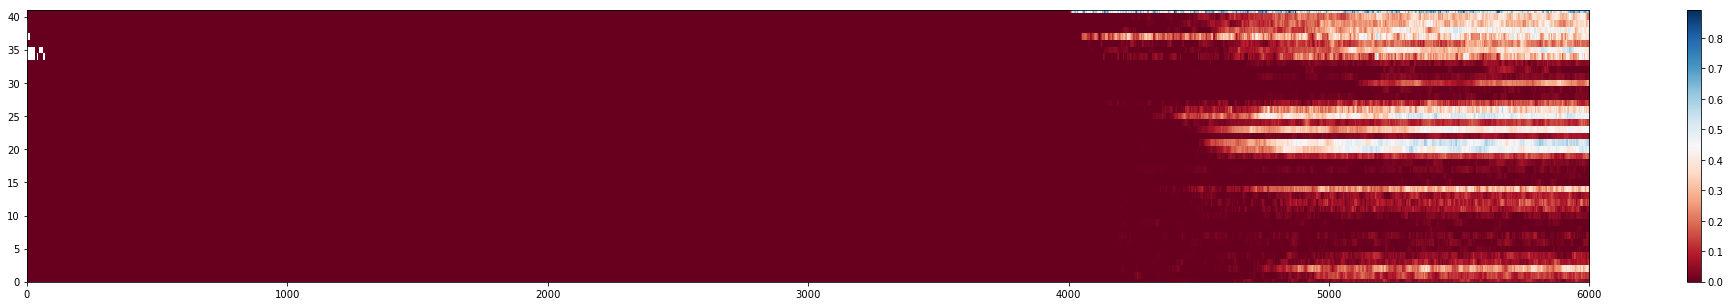

In [380]:
ratio = one_model.mis_history / (one_model.mis_history + one_model.nor_history)
plt.figure(figsize = (35, 5))
plt.imshow(ratio.T,  cmap=plt.cm.RdBu, aspect='auto')
plt.xlim(0, 6000)
plt.ylim(0, 41)
plt.colorbar()
plt.show()

In [41]:
snca

array([[ 0.59934275],
       [ 0.26101632],
       [ 0.29000476],
       [ 0.82548406],
       [ 0.64681165],
       [ 0.46708861],
       [ 0.39060002],
       [ 0.540445  ],
       [ 0.23598362],
       [ 0.07745063],
       [ 0.16678801],
       [ 1.09441929],
       [ 0.5493068 ],
       [ 0.61300713],
       [ 0.39203754],
       [ 0.12267327],
       [ 0.47482925],
       [ 0.11458936],
       [ 0.33640297],
       [ 0.07466711],
       [-0.37034188],
       [-0.94981583],
       [-0.19041772],
       [-0.30001395],
       [ 0.74709943],
       [ 0.44602376],
       [ 0.43051001],
       [ 0.75563896],
       [ 0.62976586],
       [ 0.65549983],
       [ 0.36909722],
       [ 0.64775809],
       [ 0.28991633],
       [ 0.77699072],
       [-3.33599077],
       [-2.04487788],
       [-2.00433353],
       [-2.77105086],
       [-1.67836188],
       [-0.47255766],
       [-0.79877398],
       [ 0.89528759]])

In [379]:
for t in range(1000):
    one_model.record_to_history()
    one_model.transmission_region(1)
    one_model.transmission_path(0.001)
    one_model.nor_travel()
    one_model.mis_travel()

[ 2 19 12  7  3  0  0  0  0  0  1  3  5  7 23  0  2  3  0 11 79 70  3 50 16
 68 22  5  1  1  0  2  0  3  6 13 13 13 38 32 22 26]
[ 2 18 11  7  4  0  0  0  0  0  1  3  3  9 25  0  2  3  0 11 77 72  3 49 15
 71 24  4  1  0  0  2  0  3  6 13 13 12 39 27 22 26]
[ 2 17  9  5  7  0  0  0  0  0  1  6  3 11 21  0  2  3  0 11 79 73  4 45 15
 73 25  5  1  0  0  2  0  4  6 13 13 13 43 26 22 30]
[ 4 20 12  4  6  0  0  1  0  0  1  5  4 12 19  0  2  3  0 12 77 73  4 45 15
 73 24  4  1  0  0  3  1  4  8 15 15 13 46 26 21 27]
[ 4 23 10  4  5  0  0  1  0  0  1 10  4 16 16  0  1  3  0 12 76 71  5 47 13
 72 22  5  1  0  0  3  1  4  6 16 17 12 44 23 22 28]
[ 4 22  9  4  5  0  0  1  0  0  1 11  5 15 18  0  0  3  0 13 75 71  5 44 13
 68 27  5  1  0  0  2  1  3  7 19 16 12 41 23 26 31]
[ 4 20  9  3  5  0  1  1  0  0  1 12  6 13 20  0  0  4  0 15 73 70  5 46 13
 66 26  6  1  0  0  2  1  3  6 19 15 13 42 24 22 35]
[ 5 20  8  4  5  0  1  1  0  0  1 10  8 10 25  0  0  4  0 15 71 71  5 46 14
 71 26  5  1  0  0  1

In [28]:
print(ref_model.weights[:, 0])

[  5.00000000e-01   1.09868721e-01   0.00000000e+00   0.00000000e+00
   3.36497591e-02   0.00000000e+00   1.95975993e-02   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   1.36619557e-03   0.00000000e+00   3.11679657e-04
   4.11281586e-04   6.01634015e-03   9.77070167e-03   7.71687431e-03
   1.31527236e-03   0.00000000e+00   1.53863229e-03   2.12806671e-02
   0.00000000e+00   0.00000000e+00   0.00000000e+00   2.85076141e-02
   0.00000000e+00   4.01616247e-02   2.05182233e-03   1.54469524e-02
   1.85345943e-02   0.00000000e+00   4.74075350e-03   0.00000000e+00
   3.45647835e-03   0.00000000e+00]


In [615]:
for t in range(600):
    ref_model.record_to_history()
    ref_model.nor_step_region()
    ref_model.nor_travel()

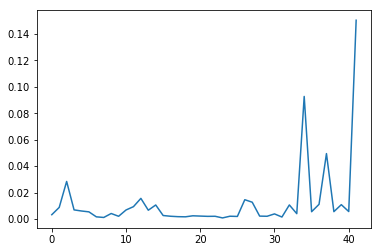

0.17210000123132613

In [681]:
plt.plot(np.arange(42), (1  - np.exp(- 7 / ref_model.nor)  ) )
#plt.plot(np.arange(42), ref_model.clearance_rate)
plt.show()
#np.max((1  - np.exp(- 1 / roi_size.flatten())  )* ref_model.nor*ref_model.clearance_rate)

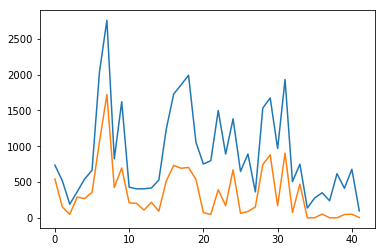

In [264]:
plt.plot(np.arange(42), ref_model.nor_history[599,:])
plt.plot(np.arange(42), ref_model.synthesis_rate * ref_model.roi_size)
plt.show()

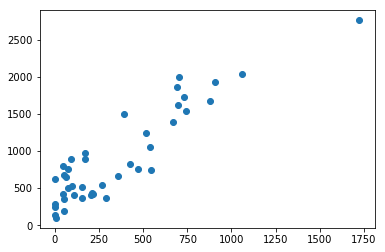

In [267]:
plt.plot(ref_model.synthesis_rate * ref_model.roi_size, ref_model.nor_history[599,:], marker = 'o', ls='')
plt.show()

In [36]:
print(norm.cdf(snca)/norm.cdf(gba))

[[  1.15690787e+00]
 [  1.14086174e+00]
 [  1.04870543e+00]
 [  1.02317342e+00]
 [  1.08578554e+00]
 [  8.76823156e-01]
 [  1.03842504e+00]
 [  8.90289158e-01]
 [  8.24914831e-01]
 [  1.11276006e+00]
 [  1.10043645e+00]
 [  1.01179406e+00]
 [  7.98874928e-01]
 [  1.29209067e+00]
 [  8.29381671e-01]
 [  1.21210413e+00]
 [  1.30687472e+00]
 [  1.38135591e+00]
 [  1.63923477e+00]
 [  1.29877197e+00]
 [  3.42789499e+00]
 [  3.68423636e+00]
 [  1.70766039e+00]
 [  8.72928303e+01]
 [  1.58000031e+00]
 [  1.26533207e+01]
 [  8.43128091e-01]
 [  9.16965475e-01]
 [  1.21504867e+00]
 [  1.08199065e+00]
 [  2.29606920e+00]
 [  1.64092023e+00]
 [  1.04559176e+00]
 [  1.02064491e+00]
 [  9.98085575e-04]
 [  3.50647031e-01]
 [  2.92358202e-01]
 [  2.47413856e-02]
 [  2.96755626e-01]
 [  4.20820030e-01]
 [  1.84835973e+00]
 [  5.17483578e-01]]


In [143]:
ref_model.nor

array([ 879,  694,  416,  632,  823,  992, 1765, 1886, 1139, 1474,  678,
        668,  701,  742,  802, 1443, 1949, 1670, 2181, 1027,  791,  937,
       1642, 1066, 1427,  865,  937,  705, 1806, 1835, 1568, 1669,  974,
       1014,  560,  791,  877,  612,  779,  816,  856,  331])

In [415]:
one_model.prob_infected

array([ 0.06729488,  0.35529803,  0.73324605,  0.12097314,  0.10151572,
        0.0747023 ,  0.00809712,  0.00237094,  0.00564572,  0.0325992 ,
        0.05016841,  0.21395461,  0.33173931,  0.1171316 ,  0.54338196,
        0.06897323,  0.08649545,  0.13763325,  0.27509847,  0.08605413,
        0.61562643,  0.78802396,  0.30775552,  0.41351404,  0.12158858,
        0.78483114,  0.91990887,  0.38547827,  0.05023546,  0.03751977,
        0.73245257,  0.14613648,  0.61959819,  0.05754343,  0.04443696,
        0.19889937,  0.12269019,  0.33397811,  0.79225181,  0.25627427,
        0.63212056,  0.96491565])

In [30]:
from scipy.io import loadmat
para2 = loadmat('/dagher/dagher6/yzheng/ICBM152_nlin_sym_09a/simulator_v3/workspace.mat')
nsconn_den = para2['nsconnDen_th']
np.sum(nsconn_den, axis = 1).shape
weights = nsconn_den / np.sum(nsconn_den, axis = 0)[np.newaxis]
print(np.sum(weights, axis = 0))

[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.]


/export02/data/anaconda/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


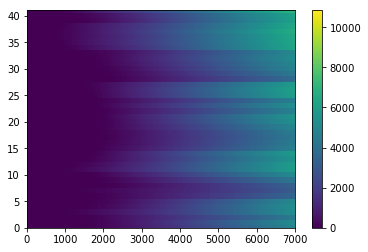

In [719]:
ratio = one_model.mis_history / (one_model.mis_history + one_model.nor_history)
plt.imshow(ratio_cum.T, aspect='auto')
plt.xlim(0, 7000)
plt.ylim(0, 41)
plt.colorbar()
plt.show()

In [718]:
weights = nsconn_den / np.sum(nsconn_den, axis = 0)[np.newaxis]
ratio_th = ratio.copy()
ratio_th[ratio<0] = 0
ratio_cum = np.dot( (1 - np.exp(-ratio_th)), weights)
ratio_cum = ratio_cum + 1-np.exp(-ratio_th)
ratio_cum = np.cumsum(ratio_cum[3000:], axis = 0)
(r, p) = pearsonr(ratio[-1, :-1], real_atrophy.flatten())
r

/export02/data/anaconda/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in less
  app.launch_new_instance()


0.33226946305995808

In [325]:
plt.plot

array([[ 1.        ,  0.47877552],
       [ 0.47877552,  1.        ]])

In [326]:
r

0.48432958286706079

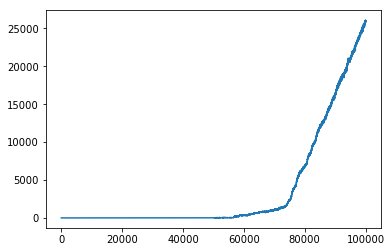

In [762]:
plt.plot(np.arange(one_model.mis_history.shape[0]), one_model.mis_history[:, 41])
plt.show()

In [149]:
ref_model.nor

array([ 98,  81,  50,  63,  84,  96, 166, 202,  93, 140,  76,  64,  66,
        80,  76, 149, 186, 173, 198,  98,  86, 112, 169, 118, 148,  73,
        98,  72, 186, 181, 161, 209,  95,  98,  63,  77,  91,  76,  74,
        74,  84,  78])

In [168]:
np.nonzero(sconn_len[41])

(array([ 4,  6,  7,  9, 34, 35, 36, 37]),)

In [169]:
sconn_len[41, np.nonzero(sconn_len[41])]

array([[ 165.14837153,  168.49995681,  167.82605699,  151.36596958,
          17.91637478,   74.84649271,   72.02182617,   32.24336325]])

In [273]:
r = np.zeros((42, 100))
for region in np.arange(42):
    """iterate through regions to find epicentre"""
    for simulation in np.arange(100):
        one_model = copy.deepcopy(ref_model)
        one_model.inject_mis(41, 1)
        for t in range(2000):
            one_model.record_to_history()
            one_model.transmission_region()
            one_model.nor_travel()
            one_model.mis_travel()
        
        ratio = one_model.mis_history / (one_model.mis_history + one_model.nor_history)
        ratio_th = ratio.copy()
        ratio_th[ratio<0.2] = 0
        ratio_cum = np.dot( (1 - np.exp(-ratio_th)), weights)
        ratio_cum = ratio_cum + 1-np.exp(-ratio_th)
        ratio_cum = np.cumsum(ratio_cum[600:], axis = 0)
        (r[region, simulation], p) = pearsonr(ratio_cum[-1, :-1], real_atrophy.flatten())
        if r[region,simulation] == np.nan:
            r[region, simulation] = 0

/export02/data/anaconda/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:13: RuntimeWarning: invalid value encountered in true_divide
/export02/data/anaconda/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:15: RuntimeWarning: invalid value encountered in less
/export02/data/anaconda/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:3029: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


In [281]:
r[np.isnan(r)] = 0

In [283]:
mean_r = np.mean(r, axis = 1)

In [298]:
sconn = loadmat('/dagher/dagher6/yzheng/ICBM152_nlin_sym_09a/sconn0712.mat')
sconn_len = sconn['sconnLen_expand']
sconn_den = sconn['sconnDen_expand']

In [45]:
print(one_model.mis_history[:, 41])

[   0    0    0 ..., 3082 3053 3070]


In [99]:
print(ref_model.synthesis_rate * roi_size.flatten())

[  8.71045629e+01   2.44279151e+01   8.07609215e+00   4.67646055e+01
   4.31845838e+01   5.71520132e+01   1.69668704e+02   2.75811527e+02
   6.80735200e+01   1.11660786e+02   3.36038559e+01   3.25342214e+01
   1.75935082e+01   3.48760295e+01   1.51401900e+01   8.25698423e+01
   1.17402206e+02   1.10985553e+02   1.12762813e+02   8.58580759e+01
   1.18964971e+01   7.71937333e+00   6.30244032e+01   2.75063723e+01
   1.07455136e+02   1.03872478e+01   1.44369335e+01   2.45134048e+01
   1.19056923e+02   1.40863963e+02   2.71009788e+01   1.45001612e+02
   1.20936880e+01   7.54361074e+01   6.59048287e-02   4.97597493e-01
   8.62870038e+00   3.75899533e-01   2.40217690e-01   7.66946222e+00
   8.40637415e+00   8.08588838e-01]


In [122]:
np.ones((3, ), dtype = np.int) * 0.01

array([ 0.01,  0.01,  0.01])

In [124]:
np.array([k for k in range(4)]) * 0.1

array([ 0. ,  0.1,  0.2,  0.3])